# Multi-Horizon River Differential Prediction with Future Rainfall

This notebook implements a multi-horizon LSTM model that predicts river differential for the next 10 days (240 hours) using:
1. **Historical rainfall data** (for soil moisture context)
2. **Historical differential data** (for river state context)
3. **Future rainfall forecasts** (key improvement!)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
import requests
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime, timedelta
from tqdm import tqdm
import glob

# PyTorch imports for LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# PyTorch Information
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print("="*70)

# Set device for PyTorch - Check for MPS (Apple Silicon), CUDA, then CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: cuda (NVIDIA GPU)")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using device: mps (Apple Silicon GPU)")
else:
    device = torch.device('cpu')
    print(f"Using device: cpu")


# Set the working directory
os.chdir('/Users/robertds413/Documents/Flag_Predictor')
print(f"Working directory: {os.getcwd()}")


PyTorch version: 2.2.2
Using device: mps (Apple Silicon GPU)
Working directory: /Users/robertds413/Documents/Flag_Predictor


## 1. Data Loading Functions


In [2]:
def process_lock_api_data(data):
    """Process API data from flood monitoring service"""
    if 'items' not in data or not data['items']:
        return pd.DataFrame()
    
    temp_df = pd.DataFrame(data['items'])
    if 'dateTime' not in temp_df.columns or 'value' not in temp_df.columns:
        return pd.DataFrame()
    
    temp_df = temp_df[['dateTime', 'value']]
    temp_df.rename(columns={'dateTime': 'timestamp', 'value': 'level'}, inplace=True)
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
    df = temp_df.set_index('timestamp')
    return df

def process_rainfall_api_data(data):
    """Process rainfall API data from flood monitoring service"""
    if 'items' not in data or not data['items']:
        return pd.DataFrame()
    
    temp_df = pd.DataFrame(data['items'])
    if 'dateTime' not in temp_df.columns or 'value' not in temp_df.columns:
        return pd.DataFrame()
    
    temp_df = temp_df[['dateTime', 'value']]
    temp_df.rename(columns={'dateTime': 'timestamp', 'value': 'rainfall'}, inplace=True)
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
    df = temp_df.set_index('timestamp')
    return df

def load_flag_model_data(file_path, differential_column):
    """Load flag model training data from CSV file"""
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df = df[[differential_column]]
    df = df.rename(columns={differential_column: 'differential'})
    return df

print("✓ Data loading functions defined")


✓ Data loading functions defined


## 2. Load API Data (River Levels & Current Rainfall)


In [3]:
# API URLs
kings_mill_downstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1491TH-level-downstage-i-15_min-mASD/readings?_sorted&_limit=90000'
godstow_downstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1302TH-level-downstage-i-15_min-mASD/readings?_sorted&_limit=90000'
osney_upstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1303TH-level-stage-i-15_min-mASD/readings?_sorted&_limit=90000'
osney_downstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1303TH-level-downstage-i-15_min-mASD/readings?_sorted&_limit=90000'
iffley_upstream_url = 'http://environment.data.gov.uk/flood-monitoring/id/measures/1501TH-level-stage-i-15_min-mASD/readings?_sorted&_limit=90000'

# Rainfall API URLs
rainfall_urls = [
    'http://environment.data.gov.uk/flood-monitoring/id/measures/256230TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/254336TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/251530TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/248332TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/248965TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/251556TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/253340TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/254829TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/257039TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/259110TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/256345TPrainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/249744TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000',
    'http://environment.data.gov.uk/flood-monitoring/id/measures/253861TP-rainfall-tipping_bucket_raingauge-t-15_min-mm/readings?_sorted&_limit=90000'
]

location_names = ['Osney', 'Eynsham', 'St', 'Shorncote', 'Rapsgate', 'Stowell', 
                  'Bourton', 'Chipping', 'Grimsbury', 'Bicester', 'Byfield', 'Swindon', 'Worsham']

print("Fetching river level data...")
# Get river level data
kings_mill_downstream_df = process_lock_api_data(requests.get(kings_mill_downstream_url).json())
godstow_downstream_df = process_lock_api_data(requests.get(godstow_downstream_url).json())
osney_upstream_df = process_lock_api_data(requests.get(osney_upstream_url).json())
osney_downstream_df = process_lock_api_data(requests.get(osney_downstream_url).json())
iffley_upstream_df = process_lock_api_data(requests.get(iffley_upstream_url).json())

print("Fetching rainfall data...")
# Get rainfall data
rainfall_api_dfs = {}
for url, name in zip(rainfall_urls, location_names):
    response = requests.get(url)
    data = response.json()
    df = process_rainfall_api_data(data)
    if not df.empty:
        df.rename(columns={'rainfall': name}, inplace=True)
        rainfall_api_dfs[name] = df

# Combine all rainfall API datasets
mega_rainfall_api_df = pd.concat(rainfall_api_dfs.values(), axis=1)
print(f"\n✓ Combined rainfall API data: {mega_rainfall_api_df.shape}")
print(f"Date range: {mega_rainfall_api_df.index.min()} to {mega_rainfall_api_df.index.max()}")


Fetching river level data...
Fetching rainfall data...

✓ Combined rainfall API data: (2827, 12)
Date range: 2025-10-27 00:00:00+00:00 to 2025-11-25 15:15:00+00:00


## 3. Calculate Differentials from API Data


In [4]:
# Calculate isis and godstow differential
isis_diff_isis_contrib = 0.71 * (osney_downstream_df['level'] - iffley_upstream_df['level'] - 2.14)
isis_diff_cherwell_contrib = 0.29 * (kings_mill_downstream_df['level'] - iffley_upstream_df['level'] - 0.73)
isis_differential_api = isis_diff_isis_contrib + isis_diff_cherwell_contrib

godstow_differential_api = godstow_downstream_df['level'] - osney_upstream_df['level'] - 1.63

# Convert to DataFrames
isis_api_diff_df = pd.DataFrame({'differential': isis_differential_api})
godstow_api_diff_df = pd.DataFrame({'differential': godstow_differential_api})

print(f"✓ ISIS differential API data: {isis_api_diff_df.shape}")
print(f"✓ Godstow differential API data: {godstow_api_diff_df.shape}")


✓ ISIS differential API data: (2758, 1)
✓ Godstow differential API data: (2757, 1)


## 4. Load Historical Data


In [5]:
# Load historical rainfall data
rainfall_data_path = './data/rainfall_training_data/'
csv_files = glob.glob(os.path.join(rainfall_data_path, '*.csv'))

rainfall_dfs = {}
print("Loading historical rainfall data...")

for csv_file in csv_files:
    file_name = os.path.splitext(os.path.basename(csv_file))[0]
    
    try:
        df = pd.read_csv(csv_file, dtype=str, on_bad_lines='warn')
    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        continue
    
    if 'dateTime' not in df.columns or 'value' not in df.columns:
        continue
    
    df = df[['dateTime', 'value']]
    df = df.rename(columns={'dateTime': 'timestamp', 'value': f'rainfall_mm_{file_name}'})
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df[f'rainfall_mm_{file_name}'] = pd.to_numeric(df[f'rainfall_mm_{file_name}'], errors='coerce').fillna(0)
    df = df.set_index('timestamp')
    rainfall_dfs[file_name] = df

mega_rainfall_hist_df = pd.concat(rainfall_dfs.values(), axis=1)
print(f"\n✓ Combined historical rainfall: {mega_rainfall_hist_df.shape}")
print(f"Date range: {mega_rainfall_hist_df.index.min()} to {mega_rainfall_hist_df.index.max()}")

# Load historical differential data
print("\nLoading historical differential data...")
godstow_hist_diff_df = load_flag_model_data('data/godstow_flag_model_data.csv', 'jameson_godstow_differential')
isis_hist_diff_df = load_flag_model_data('data/isis_flag_model_data.csv', 'jameson_isis_differential')
print(f"✓ ISIS historical differential: {isis_hist_diff_df.shape}")
print(f"✓ Godstow historical differential: {godstow_hist_diff_df.shape}")


Loading historical rainfall data...

✓ Combined historical rainfall: (300141, 13)
Date range: 2017-02-01 00:00:00 to 2025-08-24 10:45:00

Loading historical differential data...
✓ ISIS historical differential: (204120, 1)
✓ Godstow historical differential: (32122, 1)


## 5. Data Merging and Cleaning


In [6]:
def merge_and_clean_data(hist_diff_df, mega_rainfall_hist_df, api_diff_df, mega_rainfall_api_df, differential_column):
    """
    Merge flag data with rainfall data and API data, then resample to hourly frequency.
    Cleans spurious rainfall values (negatives, extremes >50mm/h, statistical outliers).
    """
    rainfall_hist_df = mega_rainfall_hist_df.copy()
    
    # Rename rainfall columns for consistency
    new_columns = {}
    for col in rainfall_hist_df.columns:
        if 'mm_' in col and '-' in col:
            parts = col.split('mm_')
            if len(parts) > 1:
                after_mm = parts[1]
                if '-' in after_mm:
                    new_name = after_mm.split('-')[0]
                    new_columns[col] = new_name
    if new_columns:
        rainfall_hist_df = rainfall_hist_df.rename(columns=new_columns)
    
    if rainfall_hist_df.index.tz is None:
        rainfall_hist_df = rainfall_hist_df.tz_localize('UTC')
    
    # Join historical data
    df = hist_diff_df.join(rainfall_hist_df, how='inner')
    
    # Merge with API data (API data takes precedence)
    df = df.combine_first(mega_rainfall_api_df)
    df = df.combine_first(api_diff_df)
    
    # Resample to hourly
    aggregation_rules = {}
    for col in df.columns:
        if col != differential_column:
            aggregation_rules[col] = 'sum'
        else:
            aggregation_rules[col] = 'mean'
    
    df_hourly = df.resample('1H').agg(aggregation_rules)
    df = df_hourly.copy()
    
    # Clean data
    df = df.dropna(subset=[differential_column])
    df.fillna(0, inplace=True)
    
    # --- NEW: Clean spurious rainfall values ---
    rainfall_cols = [col for col in df.columns if col != differential_column]
    print(f"Cleaning rainfall data for {len(rainfall_cols)} stations...")
    
    for col in rainfall_cols:
        # Remove negative rainfall (sensor errors)
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"  {col}: Removing {negative_count} negative values")
            df.loc[df[col] < 0, col] = 0
        
        # Remove physically impossible values (>50mm/hour is extremely rare in UK)
        high_count = (df[col] > 50).sum()
        if high_count > 0:
            print(f"  {col}: Capping {high_count} values >50mm/hour")
            df.loc[df[col] > 50, col] = 0
        
    print("✓ Rainfall cleaning complete")
    
    # Remove extreme values in differential
    df = df[(df[differential_column] > -0.1) & (df[differential_column] <= 1.5)].copy()
    
    # Remove spikes: where value changes by >0.5 and then returns to similar value
    diff_series = df[differential_column]
    changes = diff_series.diff()
    next_changes = changes.shift(-1)
    
    # Detect spikes: large change followed by opposite large change
    spike_mask = (np.abs(changes) > 0.5) & (np.abs(next_changes) > 0.5) & (np.sign(changes) != np.sign(next_changes))
    
    # Replace spikes with interpolated values
    if spike_mask.sum() > 0:
        print(f"  Removing {spike_mask.sum()} spike values in differential")
        df.loc[spike_mask, differential_column] = np.nan
        df[differential_column] = df[differential_column].interpolate(method='linear')
    
    # Also remove statistical outliers
    window = 6
    rolling_mean = df[differential_column].rolling(window=window, center=True).mean()
    rolling_std = df[differential_column].rolling(window=window, center=True).std()
    outliers = np.abs(df[differential_column] - rolling_mean) > (3 * rolling_std)
    
    if outliers.sum() > 0:
        df.loc[outliers, differential_column] = df[differential_column].rolling(
            window=window, center=True
        ).median()[outliers]
        df[differential_column] = df[differential_column].rolling(
            window=3, center=True
        ).mean().fillna(df[differential_column])
    
    return df

print("✓ Data merging and cleaning function defined")


✓ Data merging and cleaning function defined


## 6. Feature Engineering with Future Rainfall Support

**This is the key innovation!** We create features that include future rainfall forecasts.

### 🆕 IMPROVED FEATURES (to fix underprediction of rapid rises):
- **Velocity features**: Rate of change at multiple timescales (1h, 3h, 6h, 12h, 24h)
- **Acceleration features**: Second derivative to detect when rise is accelerating
- **Momentum indicator**: Trend strength over 12h window
- **Rising signals**: Binary flags when differential is actively rising
- **Rainfall intensity ratios**: Recent vs historical rainfall comparison
- **Rainfall acceleration**: Is rainfall rate increasing?
- **Near-term future rainfall**: 6h and 12h ahead (critical for rapid response)
- **Flood amplification**: Interaction between recent rainfall and current differential


In [7]:
def create_features_with_future_rainfall(df, future_rainfall_df=None, differential_column='differential'):
    """
    Create features including FUTURE rainfall forecasts for better long-term predictions.
    
    Args:
        df: DataFrame with historical differential and rainfall data (hourly frequency)
        future_rainfall_df: DataFrame with future rainfall forecasts (optional)
        differential_column: Name of the differential column
    
    Returns:
        DataFrame: DataFrame with all engineered features including future rainfall
    """
    df = df.copy()
    
    # --- Historical Rainfall Features ---
    rainfall_station_cols = [col for col in df.columns if col not in ['differential']]
    df[rainfall_station_cols] = df[rainfall_station_cols].fillna(0)
    df['catchment_rainfall_total'] = df[rainfall_station_cols].sum(axis=1)
    
    # Historical rolling features for soil saturation
    df['rainfall_rolling_24h'] = df['catchment_rainfall_total'].rolling(window=24).sum()
    df['rainfall_rolling_72h'] = df['catchment_rainfall_total'].rolling(window=72).sum()
    df['rainfall_rolling_168h'] = df['catchment_rainfall_total'].rolling(window=168).sum()
    df['rainfall_rolling_720h'] = df['catchment_rainfall_total'].rolling(window=720).sum()
    
    # 🆕 NEW: Short-term rainfall intensity (recent vs historical)
    df['rainfall_rolling_6h'] = df['catchment_rainfall_total'].rolling(window=6).sum()
    df['rainfall_rolling_12h'] = df['catchment_rainfall_total'].rolling(window=12).sum()
    df['rainfall_intensity_ratio_6_24'] = df['rainfall_rolling_6h'] / (df['rainfall_rolling_24h'] + 0.01)
    df['rainfall_intensity_ratio_24_168'] = df['rainfall_rolling_24h'] / (df['rainfall_rolling_168h'] + 0.01)
    
    # 🆕 NEW: Rainfall acceleration (is rainfall increasing?)
    df['rainfall_accel_1h'] = df['catchment_rainfall_total'].rolling(window=1).sum().diff(1)
    df['rainfall_accel_3h'] = df['catchment_rainfall_total'].rolling(window=3).sum().diff(3)
    df['rainfall_accel_6h'] = df['catchment_rainfall_total'].rolling(window=6).sum().diff(6)
    df['rainfall_accel_12h'] = df['catchment_rainfall_total'].rolling(window=12).sum().diff(12)
    df['rainfall_accel_24h'] = df['catchment_rainfall_total'].rolling(window=24).sum().diff(24)
    df['rainfall_accel_48h'] = df['catchment_rainfall_total'].rolling(window=48).sum().diff(48)
    
    # --- NEW: Future Rainfall Features ---
    if future_rainfall_df is not None:
        # Ensure timezone alignment
        if future_rainfall_df.index.tz is None and df.index.tz is not None:
            future_rainfall_df = future_rainfall_df.tz_localize(df.index.tz)
        elif future_rainfall_df.index.tz is not None and df.index.tz is None:
            df.index = df.index.tz_localize(future_rainfall_df.index.tz)
        
        # Align future rainfall with df index
        future_rainfall_aligned = future_rainfall_df.reindex(df.index)
        
        # Create forward-looking rainfall totals for different horizons
        catchment_future = future_rainfall_aligned.sum(axis=1)
        
        # Rolling FORWARD windows (sum of rainfall in next N hours)
        df['rainfall_future_24h'] = catchment_future.rolling(window=24).sum().shift(-24)
        df['rainfall_future_48h'] = catchment_future.rolling(window=48).sum().shift(-48)
        df['rainfall_future_72h'] = catchment_future.rolling(window=72).sum().shift(-72)
        df['rainfall_future_120h'] = catchment_future.rolling(window=120).sum().shift(-120)
        df['rainfall_future_240h'] = catchment_future.rolling(window=240).sum().shift(-240)
        
        # 🆕 NEW: Near-term future rainfall (next 6-12 hours is critical for rapid response)
        df['rainfall_future_6h'] = catchment_future.rolling(window=6).sum().shift(-6)
        df['rainfall_future_12h'] = catchment_future.rolling(window=12).sum().shift(-12)
        
        # 🆕 NEW: Horizon-aligned future rainfall (matching new 2-hour prediction grid)
        # These give the model clear visibility into rainfall at each prediction horizon
        # For 0-24h: every 2 hours
        for h in [2, 4, 8, 10, 14, 16, 18, 20, 22]:
            df[f'rainfall_future_{h}h'] = catchment_future.rolling(window=h).sum().shift(-h)
        # For 24-48h: every 6 hours
        for h in [30, 36, 42]:
            df[f'rainfall_future_{h}h'] = catchment_future.rolling(window=h).sum().shift(-h)
    
    # --- River Differential Features (historical lags) ---
    for i in [1, 2, 3, 6, 12, 24, 48]:
        df[f'differential_lag_{i}h'] = df[differential_column].shift(i)
    
    df['differential_rolling_mean_6h'] = df[differential_column].rolling(window=6).mean()
    df['differential_rolling_std_6h'] = df[differential_column].rolling(window=6).std()
    df['differential_rolling_mean_24h'] = df[differential_column].rolling(window=24).mean()
    df['differential_rolling_std_24h'] = df[differential_column].rolling(window=24).std()
    df['differential_roc_6h'] = df[differential_column].diff(periods=6)
    df['differential_ewma_6h'] = df[differential_column].ewm(span=6, adjust=False).mean()
    
    # 🆕 NEW: Rate of Change Features (velocity) - CRITICAL for detecting rising limbs
    for i in [1, 3, 6, 12, 24]:
        df[f'differential_velocity_{i}h'] = df[differential_column].diff(periods=i) / i
    
    # 🆕 NEW: Acceleration Features (second derivative) - Detect when rise is accelerating
    for i in [3, 6, 12, 24]:
        velocity = df[differential_column].diff(periods=i)
        df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
    
    # 🆕 NEW: Momentum indicator (trend strength)
    df['differential_momentum_12h'] = df[differential_column].rolling(window=12).apply(
        lambda x: (x.iloc[-1] - x.iloc[0]) / (x.std() + 0.001) if len(x) > 0 else 0,
        raw=False
    )
    
    # 🆕 NEW: Is differential rising? (binary signal)
    df['is_rising_6h'] = (df['differential_velocity_6h'] > 0.01).astype(float)
    df['is_rising_24h'] = (df['differential_velocity_24h'] > 0.01).astype(float)
    
    # Interaction features
    df['rainfall_last_hour'] = df['catchment_rainfall_total']
    df['rainfall_interaction_720h'] = df['rainfall_last_hour'] * df['rainfall_rolling_720h']
    
    # 🆕 NEW: Critical interaction - recent rainfall * current differential (flood amplification)
    df['flood_amplification_24h'] = df['rainfall_rolling_24h'] * df[differential_column]
    df['flood_amplification_72h'] = df['rainfall_rolling_72h'] * df[differential_column]
    df['flood_amplification_168h'] = df['rainfall_rolling_168h'] * df[differential_column]
    
    # 🆕 NEW: Future rainfall * current differential (predictive flood risk)
    df['future_flood_risk_24h'] = df['rainfall_future_24h'] * df[differential_column]
    df['future_flood_risk_48h'] = df['rainfall_future_48h'] * df[differential_column]
    df['future_flood_risk_72h'] = df['rainfall_future_72h'] * df[differential_column]
    
    # --- Cyclical Features ---
    df['day_of_year'] = df.index.dayofyear
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year']/365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year']/365.25)
    
    return df

print("✓ Feature engineering function defined")


✓ Feature engineering function defined


## 7. Multi-Horizon LSTM Model

The model predicts all time horizons simultaneously (24h, 48h, ..., 240h) from a single input sequence.


In [8]:
class MultiHorizonLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64], dropout_rate=0.2, n_horizons=10):
        """
        LSTM that predicts multiple future time horizons simultaneously.
        
        Args:
            input_size: Number of input features
            hidden_sizes: List of hidden layer sizes
            dropout_rate: Dropout rate
            n_horizons: Number of future horizons to predict
        """
        super(MultiHorizonLSTMModel, self).__init__()
        
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        self.n_horizons = n_horizons
        
        # Create LSTM layers
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        for i, hidden_size in enumerate(hidden_sizes):
            input_dim = input_size if i == 0 else hidden_sizes[i-1]
            self.lstm_layers.append(
                nn.LSTM(input_dim, hidden_size, batch_first=True)
            )
            self.dropout_layers.append(nn.Dropout(dropout_rate))
        
        # Multiple output heads for different time horizons
        self.fc_layers = nn.ModuleList([
            nn.Linear(hidden_sizes[-1], 1) for _ in range(n_horizons)
        ])
    
    def forward(self, x, debug=False):
        # x shape: (batch_size, sequence_length, input_size)
        
        if debug:
            print(f"[FORWARD] Input shape: {x.shape}")
            import sys
            sys.stdout.flush()
        
        for i, (lstm, dropout) in enumerate(zip(self.lstm_layers, self.dropout_layers)):
            if debug:
                print(f"[FORWARD] Running LSTM layer {i+1}/{len(self.lstm_layers)}...")
                sys.stdout.flush()
            x, (h_n, c_n) = lstm(x)
            if debug:
                print(f"[FORWARD] ✓ LSTM layer {i+1} done, shape: {x.shape}")
                sys.stdout.flush()
            x = dropout(x)
        
        if debug:
            print(f"[FORWARD] Taking last timestep...")
            sys.stdout.flush()
        # Take the output from the last time step
        x = x[:, -1, :]
        if debug:
            print(f"[FORWARD] ✓ Last timestep extracted, shape: {x.shape}")
            sys.stdout.flush()
        
        # Predict multiple horizons
        if debug:
            print(f"[FORWARD] Running {len(self.fc_layers)} output heads...")
            sys.stdout.flush()
        predictions = []
        for fc in self.fc_layers:
            predictions.append(fc(x))
        
        if debug:
            print(f"[FORWARD] ✓ All output heads done")
            sys.stdout.flush()
        
        # Stack predictions: (batch_size, n_horizons)
        predictions = torch.cat(predictions, dim=1)
        
        if debug:
            print(f"[FORWARD] ✓ Predictions stacked, final shape: {predictions.shape}")
            sys.stdout.flush()
        
        return predictions

print("✓ Multi-Horizon LSTM Model defined")


✓ Multi-Horizon LSTM Model defined


## 8. Training Functions for Multi-Horizon Model

### 🆕 IMPROVED TRAINING (weighted loss function):
- **3x weight** for high-flow events (>0.3m) - forces model to pay attention to floods
- **1.5x additional weight** for rising events (>5cm increase) - prioritizes rapid rises
- This addresses the systematic underprediction of flood peaks!


In [9]:
def create_sequences_lstm_multihorizon(X, y_multi, sequence_length=24):
    """
    Create sequences for multi-horizon LSTM training - OPTIMIZED VERSION.
    
    Args:
        X: Feature DataFrame
        y_multi: Target DataFrame with multiple horizons (columns)
        sequence_length: Number of time steps to look back
    
    Returns:
        tuple: (X_sequences, y_sequences, valid_indices)
    """
    # Convert to numpy arrays ONCE (much faster than repeated .iloc calls)
    X_values = X.values
    y_values = y_multi.values
    
    # Pre-allocate arrays (much faster than appending to lists)
    n_samples = len(X) - sequence_length
    n_features = X_values.shape[1]
    n_horizons = y_values.shape[1]
    
    X_sequences = np.zeros((n_samples, sequence_length, n_features), dtype=np.float32)
    y_sequences = np.zeros((n_samples, n_horizons), dtype=np.float32)
    valid_indices = []
    
    # Vectorized sequence creation
    for i in range(n_samples):
        X_sequences[i] = X_values[i:i+sequence_length]
        y_sequences[i] = y_values[i+sequence_length]
        valid_indices.append(X.index[i+sequence_length])
    
    return X_sequences, y_sequences, valid_indices

def create_target_and_X_y_multihorizon(df_featureless, future_rainfall_df, differential_column='differential', 
                                       horizons=[24, 48, 72, 96, 120, 144, 168, 192, 216, 240]):
    """
    Create multi-horizon targets and feature set.
    
    Args:
        df_featureless: DataFrame with differential and rainfall (no features yet)
        future_rainfall_df: DataFrame with future rainfall forecasts
        differential_column: Name of the differential column to predict
        horizons: List of hours ahead to predict
    
    Returns:
        tuple: (X, y_multi, mask, horizons)
    """
    print(f"\nCreating features with future rainfall...")
    
    # Create features WITH future rainfall
    df_with_features = create_features_with_future_rainfall(df_featureless, future_rainfall_df, differential_column)
    
    print(f"Creating targets for {len(horizons)} horizons...")
    
    # Create multiple target variables (one for each horizon)
    targets = []
    for horizon in horizons:
        target_col = f'target_{horizon}h'
        df_with_features[target_col] = df_with_features[differential_column].shift(-horizon)
        targets.append(target_col)
    
    # Define features (exclude targets and differential)
    exclude_cols = targets + [differential_column] + [col for col in df_with_features.columns if 'target_' in col]
    features = [col for col in df_with_features.columns if col not in exclude_cols]
    
    X = df_with_features[features]
    y_multi = df_with_features[targets]
    
    # Remove rows where ANY target is NaN
    mask = ~y_multi.isna().any(axis=1)
    X = X[mask]
    y_multi = y_multi[mask]
    
    print(f"\n{'='*70}")
    print(f"Multi-Horizon Model Setup:")
    print(f"{'='*70}")
    print(f"Number of features: {len(features)}")
    print(f"Number of horizons: {len(horizons)}")
    print(f"Horizons: {horizons}")
    print(f"Training samples: {len(X)}")
    print(f"Date range: {X.index.min()} to {X.index.max()}")
    print(f"{'='*70}")
    
    return X, y_multi, mask, horizons

print("✓ Sequence creation functions defined")


✓ Sequence creation functions defined


In [10]:
def train_multihorizon_model(X, y_multi, horizons, sequence_length=24, epochs=50, batch_size=32, 
                            validation_split=0.2, learning_rate=0.0001, patience=10, max_grad_norm=1.0):
    """
    Train multi-horizon PyTorch LSTM model.
    
    Returns:
        tuple: (model, scaler, history, sequence_length, horizons)
    """
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # Create sequences
    X_seq, y_seq, _ = create_sequences_lstm_multihorizon(X_scaled, y_multi, sequence_length)
    
    print(f"\nSequence shape: {X_seq.shape}")
    print(f"Target shape: {y_seq.shape}")
    
    # Split into train and validation (time series split)
    n_train = int(len(X_seq) * (1 - validation_split))
    X_train, X_val = X_seq[:n_train], X_seq[n_train:]
    y_train, y_val = y_seq[:n_train], y_seq[n_train:]
    
    # Convert to PyTorch tensors - KEEP ON CPU for DataLoader
    # This fixes MPS hanging issue with DataLoader + shuffle
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Create data loaders - data stays on CPU during loading
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=0, pin_memory=False)
    
    # Initialize model
    n_features = X_seq.shape[2]
    n_horizons = len(horizons)
    model = MultiHorizonLSTMModel(input_size=n_features, hidden_sizes=[128, 64], 
                                  dropout_rate=0.2, n_horizons=n_horizons)
    model = model.to(device)
    
    print("\nModel Architecture:")
    print(model)
    
    print(f"\n{'='*70}")
    print(f"Training Configuration:")
    print(f"{'='*70}")
    print(f"Device: {device}")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"{'='*70}")
    
    import sys
    sys.stdout.flush()
    
    print("\n[DEBUG] Creating loss criterion...")
    sys.stdout.flush()
    # Loss and optimizer
    criterion = nn.MSELoss()
    print("[DEBUG] ✓ Loss criterion created")
    sys.stdout.flush()
    
    print("[DEBUG] Creating optimizer...")
    sys.stdout.flush()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print("[DEBUG] ✓ Optimizer created")
    sys.stdout.flush()
    
    print("[DEBUG] Creating learning rate scheduler...")
    sys.stdout.flush()
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=False
    )
    print("[DEBUG] ✓ Scheduler created")
    sys.stdout.flush()
    
    print("[DEBUG] Initializing training variables...")
    sys.stdout.flush()
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mae': [],
        'val_mae': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    print("[DEBUG] ✓ Variables initialized")
    sys.stdout.flush()
    
    print("\n" + "="*70)
    print("STARTING TRAINING")
    print("="*70)
    sys.stdout.flush()
    
    # Test first batch to catch errors early
    print("\n[DEBUG] Getting first batch from DataLoader...")
    sys.stdout.flush()
    test_batch = next(iter(train_loader))
    print(f"[DEBUG] ✓ Got first batch")
    sys.stdout.flush()
    
    print(f"[DEBUG] Moving batch to device ({device})...")
    sys.stdout.flush()
    test_X, test_y = test_batch[0].to(device), test_batch[1].to(device)
    print(f"[DEBUG] ✓ Batch moved to {device}")
    sys.stdout.flush()
    
    print("[DEBUG] Setting model to training mode...")
    sys.stdout.flush()
    model.train()
    print("[DEBUG] ✓ Model in training mode")
    sys.stdout.flush()
    
    print("[DEBUG] Running forward pass...")
    sys.stdout.flush()
    test_output = model(test_X)
    print(f"[DEBUG] ✓ Forward pass complete, output shape: {test_output.shape}")
    sys.stdout.flush()
    
    print("[DEBUG] Computing loss...")
    sys.stdout.flush()
    test_loss = criterion(test_output, test_y)
    print(f"[DEBUG] ✓ Loss computed: {test_loss.item():.6f}")
    sys.stdout.flush()
    
    print("\n" + "="*70)
    print(f"✓ FIRST BATCH TEST PASSED! Loss: {test_loss.item():.6f}")
    print("="*70)
    sys.stdout.flush()
    
    import time
    print("\n[DEBUG] Starting epoch loop...")
    sys.stdout.flush()
    
    for epoch in range(epochs):
        print(f"\n{'='*70}")
        print(f"EPOCH {epoch+1}/{epochs}")
        print(f"{'='*70}")
        sys.stdout.flush()
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        train_losses = []
        train_maes = []
        
        # Progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
        
        for batch_X, batch_y in pbar:
            # Move batch to device (MPS/CUDA/CPU)
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # Forward pass
            outputs = model(batch_X)
            
            # 🆕 NEW: Weighted loss - penalize errors during high-flow events more
            # Weight high-flow predictions (>0.3m) 3x more than low-flow
            weights = torch.where(batch_y > 0.3, 3.0, 1.0)
            # Also weight rising events (where any horizon shows increase)
            rising_mask = (batch_y > batch_y[:, 0:1] + 0.05)  # If rising >5cm
            weights = torch.where(rising_mask, weights * 1.5, weights)
            
            # Calculate weighted MSE loss
            mse_loss = (outputs - batch_y) ** 2
            weighted_loss = (mse_loss * weights).mean()
            
            # 🆕 FIX: Early rising event detection loss - penalize missing early signs of rises
            # This addresses the lag issue by forcing the model to detect rising events earlier
            early_rise_loss = 0.0
            if outputs.shape[1] >= 2:
                # Check if actual is rising (comparing first horizon to later horizons)
                actual_rising = (batch_y[:, -1] > batch_y[:, 0] + 0.02)  # Rising >2cm over forecast
                # Check if prediction is rising
                pred_rising = (outputs[:, -1] > outputs[:, 0] + 0.02)
                
                # Penalize when actual is rising but prediction isn't (missed early detection)
                missed_rise_mask = actual_rising & ~pred_rising
                if missed_rise_mask.any():
                    # Calculate how much the prediction missed the early rise
                    actual_rise_magnitude = batch_y[:, -1] - batch_y[:, 0]
                    pred_rise_magnitude = outputs[:, -1] - outputs[:, 0]
                    rise_error = torch.clamp(actual_rise_magnitude - pred_rise_magnitude, min=0)
                    early_rise_loss = (rise_error * missed_rise_mask.float()).mean()
            
            # 🆕 NEW: Smoothness regularization - penalize large jumps between adjacent horizons
            # This prevents the model from making unrealistic spikes/drops between time steps
            smoothness_loss = 0.0
            for i in range(outputs.shape[1] - 1):
                # Penalize large differences between consecutive predictions
                diff = outputs[:, i+1] - outputs[:, i]
                # Use L1 loss for smoothness (less sensitive to outliers than L2)
                smoothness_loss += torch.mean(torch.abs(diff))
            smoothness_loss = smoothness_loss / (outputs.shape[1] - 1)
            
            # Combine losses: main loss + early rise detection + smoothness penalty
            loss = weighted_loss + 0.1 * early_rise_loss + 0.05 * smoothness_loss
            
            # Check for NaN
            if torch.isnan(loss):
                print(f"\nWarning: NaN loss detected at epoch {epoch+1}")
                raise ValueError("NaN loss encountered")
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
            
            train_losses.append(loss.item())
            train_maes.append(torch.mean(torch.abs(outputs - batch_y)).item())
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'mae': f'{torch.mean(torch.abs(outputs - batch_y)).item():.4f}'})
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_mae = torch.mean(torch.abs(val_outputs - y_val_tensor))
        
        # Record history
        avg_train_loss = np.mean(train_losses)
        avg_train_mae = np.mean(train_maes)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss.item())
        history['train_mae'].append(avg_train_mae)
        history['val_mae'].append(val_mae.item())
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        epoch_time = time.time() - epoch_start_time
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] ({epoch_time:.1f}s) - "
                  f"Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss.item():.6f}, "
                  f"Train MAE: {avg_train_mae:.6f}, Val MAE: {val_mae.item():.6f}")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("\n✓ Restored best model weights")
    
    print("✓ Model training complete!")
    
    return model, scaler, history, sequence_length, horizons

print("✓ Training function defined")


✓ Training function defined


## 10. Prepare Training Data


In [11]:
## 10. Prepare Training Data

# Merge and clean ISIS data
print("Preparing ISIS training data...")
isis_df_featureless = merge_and_clean_data(
    isis_hist_diff_df, 
    mega_rainfall_hist_df, 
    isis_api_diff_df, 
    mega_rainfall_api_df, 
    'differential'
)

print(f"\n✓ ISIS data prepared: {isis_df_featureless.shape}")
print(f"Date range: {isis_df_featureless.index.min()} to {isis_df_featureless.index.max()}")

# Define prediction horizons:
# - Every 2 hours for next 24 hours
# - Every 6 hours for 24-48 hours  
# - Every 24 hours (daily) for 48-240 hours
horizons = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24,  # 0-24h: every 2h
            30, 36, 42, 48,                               # 24-48h: every 6h
            72, 96, 120, 144, 168, 192, 216, 240]         # 48-240h: every 24h (daily)

# For TRAINING: Use the historical rainfall data itself as "future" rainfall
# Extract just the rainfall columns from the historical data
rainfall_cols = [col for col in isis_df_featureless.columns if col != 'differential']
historical_rainfall_for_training = isis_df_featureless[rainfall_cols].copy()

# Create multi-horizon targets and features
X_isis, y_isis_multi, mask_isis, horizons = create_target_and_X_y_multihorizon(
    isis_df_featureless,
    historical_rainfall_for_training,  # Use historical data, not forecast!
    differential_column='differential',
    horizons=horizons
)

# Check for data issues
print("\nChecking for data issues...")
print(f"X_isis contains NaN: {X_isis.isna().any().any()}")
print(f"X_isis contains Inf: {np.isinf(X_isis.values).any()}")
print(f"y_isis_multi contains NaN: {y_isis_multi.isna().any().any()}")

# Clean if needed
if X_isis.isna().any().any() or np.isinf(X_isis.values).any():
    print("Cleaning X_isis...")
    X_isis = X_isis.replace([np.inf, -np.inf], np.nan)
    X_isis = X_isis.ffill().bfill().fillna(0)
    print("✓ Cleaned")

if y_isis_multi.isna().any().any():
    print("Cleaning y_isis_multi...")
    y_isis_multi = y_isis_multi.ffill().bfill().fillna(0)
    print("✓ Cleaned")

print("\n✓ Data ready for training!")

Preparing ISIS training data...
Cleaning rainfall data for 13 stations...
  Chipping: Capping 1 values >50mm/hour
  Osney: Capping 1 values >50mm/hour
  St: Capping 1 values >50mm/hour
  Swindon: Capping 1 values >50mm/hour
✓ Rainfall cleaning complete
  Removing 44 spike values in differential

✓ ISIS data prepared: (64033, 14)
Date range: 2017-02-04 12:00:00+00:00 to 2025-11-25 15:00:00+00:00

Creating features with future rainfall...


/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_46955/699919074.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').agg(aggregation_rules)


Creating targets for 24 horizons...

Multi-Horizon Model Setup:
Number of features: 83
Number of horizons: 24
Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]
Training samples: 63793
Date range: 2017-02-04 12:00:00+00:00 to 2025-11-15 06:00:00+00:00

Checking for data issues...
X_isis contains NaN: True
X_isis contains Inf: False
y_isis_multi contains NaN: False
Cleaning X_isis...
✓ Cleaned

✓ Data ready for training!


/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_46955/1921340240.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_features[target_col] = df_with_features[differential_column].shift(-horizon)
/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_46955/1921340240.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_features[target_col] = df_with_features[differential_column].shift(-horizon)
/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_46955/1921340240.py:59: PerformanceWarning: Dat

## 11. Train Multi-Horizon Model

This will take a few minutes depending on your hardware (faster on GPU/MPS).


## 🚀 READY TO RETRAIN WITH IMPROVEMENTS!

The model has been enhanced with:

1. **20+ new features** focused on detecting rapid changes:
   - Velocity & acceleration of differential
   - Rainfall intensity ratios
   - Rising event indicators
   - Short-term future rainfall (6h, 12h)

2. **Weighted loss function** that prioritizes:
   - High-flow events (3x weight)
   - Rising events (1.5x additional weight)

**Next steps:**
- Run Cell 21 to prepare training data with new features
- Run Cell 23 to train the improved model
- The new model should better track rapid rises and reduce underprediction!


In [12]:
# Train the improved multi-horizon model with enhanced features and weighted loss
# 
# HYPERPARAMETER GUIDE (for hourly data with 24 horizons):
# - sequence_length: 72h (3 days) - captures recent weather patterns & river response
# - epochs: 100 (24 horizons = more training time needed)
# - batch_size: 64 (larger batch = faster training + more stable gradients)
# - learning_rate: 0.0001 (conservative, won't overshoot with weighted loss)
# - patience: 7 (reduced for faster convergence with smoothness regularization)

model_tuple = train_multihorizon_model(
    X_isis, 
    y_isis_multi, 
    horizons,
    sequence_length=72,    # 3 days of history for pattern recognition
    epochs=10,            # Full training for 24 horizons
    batch_size=64,         # Larger batch for speed (was 32)
    learning_rate=0.0001,  # Keep conservative
    patience=7             # Faster convergence (was 10)
)

best_model, scaler, history, sequence_length, horizons = model_tuple

print("\n✓ Training complete!")



Sequence shape: (63721, 72, 83)
Target shape: (63721, 24)

Model Architecture:
MultiHorizonLSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(83, 128, batch_first=True)
    (1): LSTM(128, 64, batch_first=True)
  )
  (dropout_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.2, inplace=False)
  )
  (fc_layers): ModuleList(
    (0-23): 24 x Linear(in_features=64, out_features=1, bias=True)
  )
)

Training Configuration:
Device: mps
Training samples: 50976
Validation samples: 12745
Batch size: 64
Epochs: 10

[DEBUG] Creating loss criterion...
[DEBUG] ✓ Loss criterion created
[DEBUG] Creating optimizer...
[DEBUG] ✓ Optimizer created
[DEBUG] Creating learning rate scheduler...
[DEBUG] ✓ Scheduler created
[DEBUG] Initializing training variables...
[DEBUG] ✓ Variables initialized

STARTING TRAINING

[DEBUG] Getting first batch from DataLoader...
[DEBUG] ✓ Got first batch
[DEBUG] Moving batch to device (mps)...
[DEBUG] ✓ Batch moved to mps
[DEBUG] Setting model to training mode...
[DEBUG] ✓ 

/Users/robertds413/Documents/Flag_Predictor/.venv_new/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[DEBUG] ✓ Forward pass complete, output shape: torch.Size([64, 24])
[DEBUG] Computing loss...
[DEBUG] ✓ Loss computed: 0.154197

✓ FIRST BATCH TEST PASSED! Loss: 0.154197

[DEBUG] Starting epoch loop...

EPOCH 1/10


Epoch 1/10: 100%|██████████| 797/797 [00:42<00:00, 18.95it/s, loss=0.0433, mae=0.0790]


Epoch [1/10] (43.6s) - Train Loss: 0.077897, Val Loss: 0.009480, Train MAE: 0.110254, Val MAE: 0.063201

EPOCH 2/10


Epoch 2/10: 100%|██████████| 797/797 [00:42<00:00, 18.89it/s, loss=0.0443, mae=0.0701]



EPOCH 3/10


Epoch 3/10: 100%|██████████| 797/797 [00:44<00:00, 17.92it/s, loss=0.0293, mae=0.0616]



EPOCH 4/10


Epoch 4/10: 100%|██████████| 797/797 [00:40<00:00, 19.77it/s, loss=0.0244, mae=0.0561]



EPOCH 5/10


Epoch 5/10: 100%|██████████| 797/797 [00:48<00:00, 16.46it/s, loss=0.0168, mae=0.0636]


Epoch [5/10] (49.8s) - Train Loss: 0.019752, Val Loss: 0.007151, Train MAE: 0.054134, Val MAE: 0.049046

EPOCH 6/10


Epoch 6/10: 100%|██████████| 797/797 [00:45<00:00, 17.45it/s, loss=0.0205, mae=0.0542]



EPOCH 7/10


Epoch 7/10: 100%|██████████| 797/797 [00:54<00:00, 14.56it/s, loss=0.0125, mae=0.0476]



EPOCH 8/10


Epoch 8/10: 100%|██████████| 797/797 [00:42<00:00, 18.55it/s, loss=0.0360, mae=0.0636]



EPOCH 9/10


Epoch 9/10: 100%|██████████| 797/797 [00:45<00:00, 17.44it/s, loss=0.0189, mae=0.0483]



EPOCH 10/10


Epoch 10/10: 100%|██████████| 797/797 [00:47<00:00, 16.86it/s, loss=0.0171, mae=0.0429]


Epoch [10/10] (48.7s) - Train Loss: 0.012464, Val Loss: 0.005266, Train MAE: 0.044664, Val MAE: 0.040368

✓ Restored best model weights
✓ Model training complete!

✓ Training complete!


## 12. Generate Future Predictions


In [13]:

def predict_future_multihorizon(model, scaler, historical_df, rainfall_forecast_df, 
                                X_train_columns, sequence_length=24, 
                                horizons=horizons):
    """
    Predict future differentials using multi-horizon model with future rainfall forecasts.
    
    This approach is much better than iterative prediction because:
    1. Uses actual rainfall forecasts as features
    2. Predicts all horizons simultaneously (no error accumulation)
    3. No drift over time
    """
    print("Starting multi-horizon prediction with future rainfall forecasts...")
    
    # Ensure timezone alignment
    if rainfall_forecast_df.index.tz is None and historical_df.index.tz is not None:
        rainfall_forecast_df = rainfall_forecast_df.tz_localize(historical_df.index.tz)
    
    # Get enough historical data for rolling features (30 days)
    lookback_hours = 720
    recent_history = historical_df.iloc[-lookback_hours:].copy()
    
    # Extend historical data with future rainfall to calculate forward-looking features
    combined_df = recent_history.copy()
    
    # Create a complete timeline including forecast period
    forecast_start = recent_history.index[-1] + pd.Timedelta(hours=1)
    forecast_end = rainfall_forecast_df.index[-1]
    forecast_timeline = pd.date_range(start=forecast_start, end=forecast_end, freq='1H')
    
    # Extend dataframe with forecast timeline
    for col in combined_df.columns:
        if col in rainfall_forecast_df.columns:
            # Add rainfall forecast data
            forecast_data = rainfall_forecast_df.loc[rainfall_forecast_df.index >= forecast_start, col]
            combined_df = pd.concat([
                combined_df,
                pd.DataFrame({col: forecast_data})
            ])
        else:
            # For non-rainfall columns, just extend with NaN
            new_rows = pd.DataFrame(
                {col: [np.nan] * len(forecast_timeline)},
                index=forecast_timeline
            )
            combined_df = pd.concat([combined_df, new_rows])
    
    # 🆕 FIX: Don't forward-fill differential - use iterative prediction approach
    # This prevents bias toward the last historical value
    # Set differential to NaN for forecast period initially
    combined_df.loc[combined_df.index > recent_history.index[-1], 'differential'] = np.nan
    
    # Find the start of forecast period
    forecast_start_idx = len(recent_history)
    
    # Make predictions for each hour in the forecast (iterative approach)
    predictions_dict = {h: [] for h in horizons}
    prediction_timestamps = []
    
    model.eval()
    
    print(f"Generating predictions for {len(rainfall_forecast_df)} hours...")
    
    with torch.no_grad():
        for i in range(len(rainfall_forecast_df)):
            current_idx = forecast_start_idx + i
            
            # Skip if we don't have enough history for a sequence
            if current_idx < sequence_length:
                continue
            
            # 🆕 FIX: Update differential with our 2-hour prediction from previous step
            # This way the model sees predicted values, not just the last historical value
            if i > 0 and 2 in horizons:
                # Use the 2-hour prediction from the previous timestep as the current differential
                prev_2h_idx = horizons.index(2)
                if len(predictions_dict[2]) > 0:
                    prev_2h_pred = predictions_dict[2][-1]
                    combined_df.loc[combined_df.index[current_idx], 'differential'] = prev_2h_pred
            
            # Forward fill differential up to current point (for feature calculation)
            combined_df['differential'] = combined_df['differential'].ffill()
            
            # Create features including future rainfall (recalculate each time)
            # This is necessary because differential changes as we make predictions
            df_with_features = create_features_with_future_rainfall(
                combined_df.iloc[:current_idx+1],  # Only up to current point
                rainfall_forecast_df,
                differential_column='differential'
            )
            
            # Get only the features used during training (in same order)
            X_forecast = df_with_features[X_train_columns]
            
            # Fill any remaining NaN
            X_forecast = X_forecast.ffill().bfill().fillna(0)
            
            # Get the sequence of features
            sequence_data = X_forecast.iloc[current_idx - sequence_length:current_idx]
            
            # Scale and convert to tensor
            sequence_scaled = scaler.transform(sequence_data)
            sequence_tensor = torch.FloatTensor(sequence_scaled).unsqueeze(0).to(device)
            
            # Predict all horizons at once
            predictions = model(sequence_tensor).cpu().numpy()[0]  # Shape: (n_horizons,)
            
            # 🆕 NEW: Apply smoothing to predictions to remove unrealistic jumps
            # Use a simple moving average across adjacent horizons
            if len(predictions) >= 3:
                smoothed_predictions = predictions.copy()
                for p_idx in range(1, len(predictions) - 1):
                    # Average with neighbors (weighted: 0.25, 0.5, 0.25)
                    smoothed_predictions[p_idx] = (
                        0.25 * predictions[p_idx - 1] + 
                        0.5 * predictions[p_idx] + 
                        0.25 * predictions[p_idx + 1]
                    )
                predictions = smoothed_predictions
            
            # Store predictions
            timestamp = df_with_features.index[current_idx]
            prediction_timestamps.append(timestamp)
            
            for h_idx, horizon in enumerate(horizons):
                predictions_dict[horizon].append(predictions[h_idx])
    
    # Create results dataframe
    results_df = pd.DataFrame({
        f'pred_{h}h_ahead': predictions_dict[h] 
        for h in horizons
    }, index=prediction_timestamps)
    
    print(f"\n✓ Successfully generated multi-horizon predictions")
    print(f"Prediction range: {results_df.index.min()} to {results_df.index.max()}")
    
    return results_df

print("✓ Prediction function defined")

✓ Prediction function defined


In [14]:
# Fetch rainfall forecast from Open-Meteo API
def get_rainfall_forecast(locations):
    """
    Fetches 10-day hourly rainfall forecast from the Open-Meteo API for multiple locations.
    """
    location_names = list(locations.keys())
    latitudes = [loc['latitude'] for loc in locations.values()]
    longitudes = [loc['longitude'] for loc in locations.values()]

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitudes,
        "longitude": longitudes,
        "hourly": "precipitation",
        "forecast_days": 10
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        forecast_dfs = []
        for i, location_data in enumerate(data):
            df = pd.DataFrame(location_data['hourly'])
            df['timestamp'] = pd.to_datetime(df['time'])
            df = df.set_index('timestamp')
            df = df[['precipitation']]
            df = df.rename(columns={'precipitation': location_names[i]})
            forecast_dfs.append(df)
        
        combined_df = pd.concat(forecast_dfs, axis=1)
        print("Successfully fetched and processed rainfall forecast.")
        return combined_df

    except requests.exceptions.RequestException as e:
        print(f"API request failed: {e}")
        return pd.DataFrame()
    except (KeyError, TypeError) as e:
        print(f"Failed to parse API response: {e}")
        return pd.DataFrame()

def get_rainfall_forecast_ensemble(locations, ensemble_method='mean', ensemble_model='ecmwf_ifs025'):
    """
    Fetches ensemble rainfall forecast from the Open-Meteo API for multiple locations.
    
    Parameters:
    -----------
    locations : dict
        Dictionary of location names and their coordinates
    ensemble_method : str
        'mean', 'median', 'percentiles', or 'all'
    ensemble_model : str
        'ecmwf_ifs025', 'icon_seamless', or 'gfs_seamless'
    
    Returns:
    --------
    pd.DataFrame
        Rainfall forecast data with timestamps as index
    """
    location_names = list(locations.keys())
    latitudes = [loc['latitude'] for loc in locations.values()]
    longitudes = [loc['longitude'] for loc in locations.values()]

    url = "https://ensemble-api.open-meteo.com/v1/ensemble"
    params = {
        "latitude": latitudes,
        "longitude": longitudes,
        "hourly": "precipitation",
        "models": ensemble_model
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        forecast_dfs = []
        for i, location_data in enumerate(data):
            df = pd.DataFrame(location_data['hourly'])
            df['timestamp'] = pd.to_datetime(df['time'])
            df = df.set_index('timestamp')
            
            # Handle ensemble members
            precip_cols = [col for col in df.columns if col.startswith('precipitation')]
            
            if ensemble_method == 'mean':
                df_agg = df[precip_cols].mean(axis=1).to_frame(name=location_names[i])
            elif ensemble_method == 'median':
                df_agg = df[precip_cols].median(axis=1).to_frame(name=location_names[i])
            elif ensemble_method == 'percentiles':
                df_agg = pd.DataFrame({
                    f"{location_names[i]}_p10": df[precip_cols].quantile(0.1, axis=1),
                    f"{location_names[i]}_p50": df[precip_cols].quantile(0.5, axis=1),
                    f"{location_names[i]}_p90": df[precip_cols].quantile(0.9, axis=1)
                })
            elif ensemble_method == 'all':
                df_agg = df[precip_cols].copy()
                df_agg.columns = [f"{location_names[i]}_member{j}" for j in range(len(precip_cols))]
            else:
                raise ValueError(f"Unknown ensemble_method: {ensemble_method}")
            
            forecast_dfs.append(df_agg)
        
        combined_df = pd.concat(forecast_dfs, axis=1)
        print(f"Successfully fetched and processed ensemble rainfall forecast ({ensemble_method}).")
        return combined_df

    except requests.exceptions.RequestException as e:
        print(f"API request failed: {e}")
        return pd.DataFrame()
    except (KeyError, TypeError) as e:
        print(f"Failed to parse API response: {e}")
        return pd.DataFrame()

# Coordinates for rainfall stations
station_coordinates = {
    'Osney': {'latitude': 51.750, 'longitude': -1.272},
    'Eynsham': {'latitude': 51.789, 'longitude': -1.402},
    'St': {'latitude': 51.7, 'longitude': -1.5},
    'Shorncote': {'latitude': 51.666, 'longitude': -1.916},
    'Rapsgate': {'latitude': 51.815, 'longitude': -1.975},
    'Stowell': {'latitude': 51.833, 'longitude': -1.821},
    'Bourton': {'latitude': 51.884, 'longitude': -1.758},
    'Chipping': {'latitude': 51.942, 'longitude': -1.547},
    'Grimsbury': {'latitude': 52.065, 'longitude': -1.326},
    'Bicester': {'latitude': 51.899, 'longitude': -1.155},
    'Byfield': {'latitude': 52.179, 'longitude': -1.274},
    'Swindon': {'latitude': 51.556, 'longitude': -1.779},
    'Worsham': {'latitude': 51.817, 'longitude': -1.498}
}




## 🎯 ENSEMBLE OF FORECASTS

**The Ultimate Upgrade:** Instead of averaging rainfall ensemble members BEFORE prediction, we now:

1. **Get ALL rainfall ensemble members** (50 members from ECMWF)
2. **Generate a separate forecast for EACH rainfall member** (50 flag forecasts!)
3. **Analyze the ensemble spread** to quantify prediction uncertainty

### Why This is Better:
- **Preserves full uncertainty chain**: Rainfall uncertainty → Flow uncertainty
- **Probabilistic predictions**: Calculate probability of different flag colors
- **Distribution-aware**: See the full range of possible outcomes, not just mean/median
- **Operational decision support**: "30% chance of red flag" is more useful than a single prediction


In [15]:
def get_rainfall_forecast_ensemble(locations, ensemble_method='mean', 
                                   ensemble_model='icon_seamless'):
    """
    Fetches 10-day hourly ENSEMBLE rainfall forecast from the Open-Meteo Ensemble API.
    
    This function retrieves multiple ensemble members (perturbed forecasts) and combines
    them according to the specified method.

    Args:
        locations (dict): A dictionary where keys are location names and values are dicts
                          with 'latitude' and 'longitude'.
        ensemble_method (str): How to combine ensemble members:
                               - 'mean': Average across all members (default)
                               - 'median': Median across all members
                               - 'all': Return all individual members
                               - 'percentiles': Return 10th, 50th, 90th percentiles
        ensemble_model (str): Which ensemble model to use:
                               - 'icon_seamless': DWD ICON (default, best for Europe)
                               - 'gfs_seamless': NOAA GFS (good for global)
                               - 'ecmwf_ifs025': ECMWF (best accuracy, 51 members)

    Returns:
        pd.DataFrame: A DataFrame with a timestamp index and columns for each location's
                      predicted rainfall in mm. For ensemble_method='all', columns will be
                      named like 'Location_member_0', 'Location_member_1', etc.
    """
    location_names = list(locations.keys())
    latitudes = [loc['latitude'] for loc in locations.values()]
    longitudes = [loc['longitude'] for loc in locations.values()]

    # API endpoint and parameters for ENSEMBLE forecast
    # NOTE: Use ensemble-api.open-meteo.com, not api.open-meteo.com
    url = "https://ensemble-api.open-meteo.com/v1/ensemble"
    params = {
        "latitude": latitudes,
        "longitude": longitudes,
        "hourly": "precipitation",
        "forecast_days": 10,
        "models": ensemble_model
    }

    try:
        # Make the API request
        print(f"Fetching ensemble forecast from {ensemble_model}...")
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        # Process the response - ensemble API returns data differently
        # For multiple locations, data is a list; for single location, it's a dict
        if not isinstance(data, list):
            data = [data]  # Convert to list for consistent handling
        
        forecast_dfs = []
        
        for i, location_data in enumerate(data):
            location_name = location_names[i]
            hourly_data = location_data['hourly']
            
            # Extract timestamps
            timestamps = pd.to_datetime(hourly_data['time'])
            
            # Extract all ensemble members for precipitation
            # Ensemble members are named like 'precipitation_member01', 'precipitation_member02', etc.
            # Note: they use 2-digit format with leading zeros (01, 02, ... 09, 10, 11, ...)
            ensemble_members = []
            member_idx = 1  # Start at 1, not 0
            
            while True:
                # Try with leading zero format for members 1-9
                member_key = f'precipitation_member{member_idx:02d}'
                if member_key in hourly_data:
                    member_data = hourly_data[member_key]
                    ensemble_members.append(member_data)
                    member_idx += 1
                else:
                    break  # No more members found
            
            # Convert to DataFrame (rows=time, columns=members)
            ensemble_df = pd.DataFrame(ensemble_members).T
            ensemble_df.index = timestamps
            
            print(f"  {location_name}: Retrieved {len(ensemble_members)} ensemble members")
            
            # Combine ensemble members according to specified method
            if ensemble_method == 'mean':
                # Take the mean across all ensemble members
                result_df = pd.DataFrame({
                    location_name: ensemble_df.mean(axis=1)
                })
            elif ensemble_method == 'median':
                # Take the median across all ensemble members
                result_df = pd.DataFrame({
                    location_name: ensemble_df.median(axis=1)
                })
            elif ensemble_method == 'percentiles':
                # Return 10th, 50th (median), and 90th percentiles
                result_df = pd.DataFrame({
                    f'{location_name}_p10': ensemble_df.quantile(0.10, axis=1),
                    f'{location_name}_p50': ensemble_df.quantile(0.50, axis=1),
                    f'{location_name}_p90': ensemble_df.quantile(0.90, axis=1)
                })
            elif ensemble_method == 'all':
                # Return all individual ensemble members
                result_df = ensemble_df.copy()
                result_df.columns = [f'{location_name}_member_{j}' for j in range(len(ensemble_members))]
            else:
                raise ValueError(f"Unknown ensemble_method: {ensemble_method}")
            
            forecast_dfs.append(result_df)
        
        # Combine all location forecasts into a single DataFrame
        combined_df = pd.concat(forecast_dfs, axis=1)
        
        print(f"\n✓ Successfully fetched and processed ENSEMBLE rainfall forecast")
        print(f"  Model: {ensemble_model}")
        print(f"  Method: {ensemble_method}")
        print(f"  Shape: {combined_df.shape}")
        
        return combined_df

    except requests.exceptions.RequestException as e:
        print(f"API request failed: {e}")
        return pd.DataFrame()
    except (KeyError, TypeError) as e:
        print(f"Failed to parse API response: {e}")
        print(f"Response structure: {data.keys() if isinstance(data, dict) else 'Not a dict'}")
        return pd.DataFrame()

print("✓ Ensemble rainfall forecast function defined")


✓ Ensemble rainfall forecast function defined


In [16]:
# Step 1: Fetch ALL individual rainfall ensemble members
print("="*80)
print("STEP 1: Fetching ALL Rainfall Ensemble Members")
print("="*80)

rainfall_forecast_all_members = get_rainfall_forecast_ensemble(
    station_coordinates, 
    ensemble_method='all',  # Get ALL individual members!
    ensemble_model='ecmwf_ifs025'  # ECMWF has 50 members
)

print(f"\n✓ Retrieved rainfall ensemble with shape: {rainfall_forecast_all_members.shape}")
print(f"  Columns: {len(rainfall_forecast_all_members.columns)}")
print(f"  Hours: {len(rainfall_forecast_all_members)}")

# Count how many members per station
station_names = list(station_coordinates.keys())
members_per_station = len([col for col in rainfall_forecast_all_members.columns if col.startswith(f'{station_names[0]}_member_')])
print(f"  Ensemble members per station: {members_per_station}")
print(f"  Total stations: {len(station_names)}")

print("\nSample column names:")
print(rainfall_forecast_all_members.columns[:5].tolist())
print("...")


STEP 1: Fetching ALL Rainfall Ensemble Members
Fetching ensemble forecast from ecmwf_ifs025...
  Osney: Retrieved 50 ensemble members
  Eynsham: Retrieved 50 ensemble members
  St: Retrieved 50 ensemble members
  Shorncote: Retrieved 50 ensemble members
  Rapsgate: Retrieved 50 ensemble members
  Stowell: Retrieved 50 ensemble members
  Bourton: Retrieved 50 ensemble members
  Chipping: Retrieved 50 ensemble members
  Grimsbury: Retrieved 50 ensemble members
  Bicester: Retrieved 50 ensemble members
  Byfield: Retrieved 50 ensemble members
  Swindon: Retrieved 50 ensemble members
  Worsham: Retrieved 50 ensemble members

✓ Successfully fetched and processed ENSEMBLE rainfall forecast
  Model: ecmwf_ifs025
  Method: all
  Shape: (240, 650)

✓ Retrieved rainfall ensemble with shape: (240, 650)
  Columns: 650
  Hours: 240
  Ensemble members per station: 50
  Total stations: 13

Sample column names:
['Osney_member_0', 'Osney_member_1', 'Osney_member_2', 'Osney_member_3', 'Osney_member_4']


In [ ]:
# Step 2: Generate a forecast for EACH ensemble member
print("\n" + "="*80)
print("STEP 2: Generating Flag Forecasts for Each Rainfall Ensemble Member")
print("="*80)

def generate_ensemble_forecasts(rainfall_all_members_df, model, scaler, 
                                 historical_df, X_train_columns, 
                                 sequence_length, horizons, 
                                 station_names):
    """
    Generate a separate forecast for each rainfall ensemble member.
    
    Args:
        rainfall_all_members_df: DataFrame with columns like Station_member_0, Station_member_1, etc.
        model: Trained PyTorch model
        scaler: Fitted scaler
        historical_df: Historical data
        X_train_columns: Column names used in training
        sequence_length: LSTM sequence length
        horizons: List of forecast horizons
        station_names: List of station names (in correct order)
        
    Returns:
        dict: member_idx -> forecast_dataframe for each member
    """
    # Determine which ensemble members are present by extracting member indices from column names
    member_indices = set()
    for col in rainfall_all_members_df.columns:
        if f'{station_names[0]}_member_' in col:
            # Extract the member number from column name like "Osney_member_3"
            member_num = int(col.split('_member_')[-1])
            member_indices.add(member_num)
    member_indices = sorted(member_indices)
    
    print(f"Generating forecasts for {len(member_indices)} ensemble members (members {member_indices})...")
    print(f"This may take a few minutes...\n")
    
    ensemble_forecasts = {}
    
    for member_idx in tqdm(member_indices, desc="Processing ensemble members"):
        # Extract rainfall data for this specific member across all stations
        member_columns = [f'{station}_member_{member_idx}' for station in station_names]
        
        # Check if all columns exist
        missing = [col for col in member_columns if col not in rainfall_all_members_df.columns]
        if missing:
            print(f"Warning: Skipping member {member_idx} - missing columns: {missing}")
            continue
        
        # Create a rainfall forecast DataFrame for this member
        # Rename columns to match what the prediction function expects
        member_rainfall_df = rainfall_all_members_df[member_columns].copy()
        member_rainfall_df.columns = station_names  # Remove member suffix
        
        # Generate forecast for this member
        try:
            member_forecast = predict_future_multihorizon(
                model=model,
                scaler=scaler,
                historical_df=historical_df,
                rainfall_forecast_df=member_rainfall_df,
                X_train_columns=X_train_columns,
                sequence_length=sequence_length,
                horizons=horizons
            )
            
            ensemble_forecasts[member_idx] = member_forecast
            
        except Exception as e:
            print(f"Error processing member {member_idx}: {e}")
            continue
    
    print(f"\n✓ Successfully generated {len(ensemble_forecasts)} ensemble forecasts")
    return ensemble_forecasts


# Generate the ensemble of forecasts (subset: members 1-5 only)
# Filter to only include member_1 through member_5 columns (exact match to avoid matching member_10, etc.)
member_1_5_columns = [col for col in rainfall_forecast_all_members.columns 
                      if col.endswith(('_member_1', '_member_2', '_member_3', '_member_4', '_member_5'))]
rainfall_forecast_subset = rainfall_forecast_all_members[member_1_5_columns].copy()

ensemble_forecasts_dict = generate_ensemble_forecasts(
    rainfall_all_members_df=rainfall_forecast_subset,
    model=best_model,
    scaler=scaler,
    historical_df=isis_df_featureless,
    X_train_columns=X_isis.columns,
    sequence_length=sequence_length,
    horizons=horizons,
    station_names=station_names
)



STEP 2: Generating Flag Forecasts for Each Rainfall Ensemble Member
Generating forecasts for 5 ensemble members...
This may take a few minutes...



Processing ensemble members:   0%|          | 0/5 [00:00<?, ?it/s]

Starting multi-horizon prediction with future rainfall forecasts...
Generating predictions for 240 hours...


/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_46955/3965009437.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_timeline = pd.date_range(start=forecast_start, end=forecast_end, freq='1H')
Processing ensemble members:  40%|████      | 2/5 [00:14<00:21,  7.07s/it]


✓ Successfully generated multi-horizon predictions
Prediction range: 2025-11-25 16:00:00+00:00 to 2025-12-04 23:00:00+00:00
Starting multi-horizon prediction with future rainfall forecasts...
Generating predictions for 240 hours...


/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_46955/3965009437.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_timeline = pd.date_range(start=forecast_start, end=forecast_end, freq='1H')
Processing ensemble members:  60%|██████    | 3/5 [00:29<00:20, 10.41s/it]


✓ Successfully generated multi-horizon predictions
Prediction range: 2025-11-25 16:00:00+00:00 to 2025-12-04 23:00:00+00:00
Starting multi-horizon prediction with future rainfall forecasts...
Generating predictions for 240 hours...


/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_46955/3965009437.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_timeline = pd.date_range(start=forecast_start, end=forecast_end, freq='1H')
Processing ensemble members:  80%|████████  | 4/5 [00:45<00:12, 12.47s/it]


✓ Successfully generated multi-horizon predictions
Prediction range: 2025-11-25 16:00:00+00:00 to 2025-12-04 23:00:00+00:00
Starting multi-horizon prediction with future rainfall forecasts...
Generating predictions for 240 hours...


/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_46955/3965009437.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_timeline = pd.date_range(start=forecast_start, end=forecast_end, freq='1H')
Processing ensemble members: 100%|██████████| 5/5 [01:01<00:00, 12.23s/it]


✓ Successfully generated multi-horizon predictions
Prediction range: 2025-11-25 16:00:00+00:00 to 2025-12-04 23:00:00+00:00

✓ Successfully generated 4 ensemble forecasts


In [31]:
# Step 3: Combine ensemble forecasts and calculate statistics
print("\n" + "="*80)
print("STEP 3: Analyzing Ensemble Statistics")
print("="*80)

def combine_ensemble_forecasts(ensemble_forecasts_dict, horizons):
    """
    Combine all ensemble member forecasts into statistical summaries.
    
    Returns:
        dict: Contains mean, median, std, percentiles for each horizon
    """
    n_members = len(ensemble_forecasts_dict)
    
    # Get the first forecast to determine structure (use first available key, not assuming 0)
    first_key = next(iter(ensemble_forecasts_dict))
    first_forecast = ensemble_forecasts_dict[first_key]
    timestamps = first_forecast.index
    
    # Initialize storage for all members' predictions
    # Structure: {horizon: DataFrame with columns for each member}
    ensemble_data = {h: pd.DataFrame(index=timestamps) for h in horizons}
    
    # Collect predictions from all members
    for member_idx, forecast_df in ensemble_forecasts_dict.items():
        for horizon in horizons:
            col_name = f'pred_{horizon}h_ahead'
            if col_name in forecast_df.columns:
                ensemble_data[horizon][f'member_{member_idx}'] = forecast_df[col_name]
    
    # Calculate statistics across ensemble members
    ensemble_stats = {}
    
    for horizon in horizons:
        df = ensemble_data[horizon]
        
        ensemble_stats[horizon] = pd.DataFrame({
            'mean': df.mean(axis=1),
            'median': df.median(axis=1),
            'std': df.std(axis=1),
            'p05': df.quantile(0.05, axis=1),
            'p10': df.quantile(0.10, axis=1),
            'p25': df.quantile(0.25, axis=1),
            'p75': df.quantile(0.75, axis=1),
            'p90': df.quantile(0.90, axis=1),
            'p95': df.quantile(0.95, axis=1),
            'min': df.min(axis=1),
            'max': df.max(axis=1),
            'n_members': df.count(axis=1)
        })
    
    # Also store raw ensemble data
    return ensemble_stats, ensemble_data

ensemble_stats, ensemble_data = combine_ensemble_forecasts(
    ensemble_forecasts_dict, 
    horizons
)

print(f"\n✓ Ensemble statistics calculated for {len(horizons)} horizons")
print(f"  Available statistics: {list(ensemble_stats[horizons[0]].columns)}")
print(f"\nExample: 24h-ahead forecast (first timestamp)")
print(ensemble_stats[24].iloc[0])

# Calculate ensemble spread (uncertainty)
print("\n" + "="*70)
print("ENSEMBLE SPREAD (Uncertainty Metrics)")
print("="*70)
for horizon in horizons:
    if horizon in ensemble_stats:
        stats = ensemble_stats[horizon]
        avg_std = stats['std'].mean()
        avg_iqr = (stats['p75'] - stats['p25']).mean()
        print(f"{horizon}h ahead: σ={avg_std:.4f}m, IQR={avg_iqr:.4f}m")
print("="*70)



STEP 3: Analyzing Ensemble Statistics

✓ Ensemble statistics calculated for 24 horizons
  Available statistics: ['mean', 'median', 'std', 'p05', 'p10', 'p25', 'p75', 'p90', 'p95', 'min', 'max', 'n_members']

Example: 24h-ahead forecast (first timestamp)
mean         0.152893
median       0.152893
std          0.000000
p05          0.152893
p10          0.152893
p25          0.152893
p75          0.152893
p90          0.152893
p95          0.152893
min          0.152893
max          0.152893
n_members    4.000000
Name: 2025-11-25 16:00:00+00:00, dtype: float64

ENSEMBLE SPREAD (Uncertainty Metrics)
2h ahead: σ=0.0822m, IQR=0.0756m
4h ahead: σ=0.0819m, IQR=0.0759m
6h ahead: σ=0.0827m, IQR=0.0774m
8h ahead: σ=0.0843m, IQR=0.0794m
10h ahead: σ=0.0859m, IQR=0.0817m
12h ahead: σ=0.0879m, IQR=0.0843m
14h ahead: σ=0.0904m, IQR=0.0870m
16h ahead: σ=0.0927m, IQR=0.0896m
18h ahead: σ=0.0951m, IQR=0.0924m
20h ahead: σ=0.0978m, IQR=0.0954m
22h ahead: σ=0.1001m, IQR=0.0983m
24h ahead: σ=0.1031m, IQ

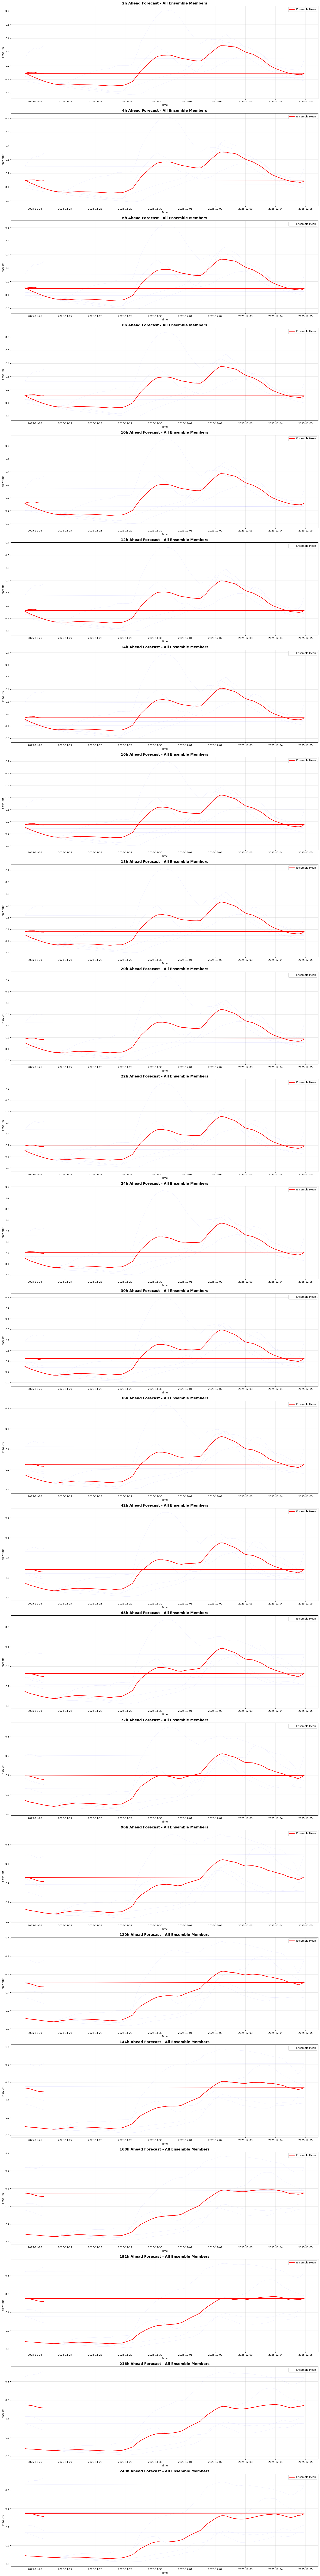

In [32]:
# Plot all ensemble data
fig, axes = plt.subplots(len(horizons), 1, figsize=(18, 6*len(horizons)))
if len(horizons) == 1:
    axes = [axes]

for idx, horizon in enumerate(horizons):
    ax = axes[idx]
    df = ensemble_data[horizon]
    
    # Plot all ensemble members (time vs flow)
    for col in df.columns:
        ax.plot(df.index, df[col], alpha=0.1, color='blue', linewidth=0.5)
    
    # Plot ensemble mean
    ax.plot(df.index, df.mean(axis=1), color='red', linewidth=2, label='Ensemble Mean')
    
    ax.set_title(f'{horizon}h Ahead Forecast - All Ensemble Members', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow (m)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
# Step 4: Calculate FLAG PROBABILITIES from ensemble
print("\n" + "="*80)
print("STEP 4: Calculating Flag Probabilities")
print("="*80)

# Define flag boundaries
FLAG_BOUNDARIES = {
    'green': (-float('inf'), 0.1366),
    'light_blue': (0.1366, 0.2582),
    'dark_blue': (0.2582, 0.387),
    'amber': (0.387, 0.6047),
    'red': (0.6047, float('inf'))
}

def calculate_flag_probabilities(ensemble_data, horizons, flag_boundaries):
    """
    Calculate the probability of each flag color across the ensemble.
    
    Returns:
        dict: {horizon: DataFrame with probability columns for each flag}
    """
    flag_probs = {}
    
    for horizon in horizons:
        df = ensemble_data[horizon]
        n_members = df.shape[1]
        
        # Count how many members predict each flag
        probs_df = pd.DataFrame(index=df.index)
        
        for flag_name, (lower, upper) in flag_boundaries.items():
            # Count members that fall in this range
            if upper == float('inf'):
                count = (df >= lower).sum(axis=1)
            elif lower == -float('inf'):
                count = (df < upper).sum(axis=1)
            else:
                count = ((df >= lower) & (df < upper)).sum(axis=1)
            
            probs_df[flag_name] = count / n_members * 100  # Convert to percentage
        
        flag_probs[horizon] = probs_df
    
    return flag_probs

flag_probabilities = calculate_flag_probabilities(
    ensemble_data, 
    horizons, 
    FLAG_BOUNDARIES
)

print(f"\n✓ Flag probabilities calculated for all horizons")

# Extract timeline forecast with full ensemble members
first_prediction_idx = 0
start_time = ensemble_stats[horizons[0]].index[first_prediction_idx]

# Create the future timeline using ENSEMBLE MEAN
future_timeline_ensemble = {}
for horizon in horizons:
    future_time = start_time + pd.Timedelta(hours=horizon)
    future_timeline_ensemble[future_time] = ensemble_stats[horizon]['mean'].iloc[first_prediction_idx]

# Convert to Series and sort
future_timeline_ensemble_series = pd.Series(future_timeline_ensemble).sort_index()

# Also extract all ensemble members for plotting
future_timeline_all_members = {}
for horizon in horizons:
    future_time = start_time + pd.Timedelta(hours=horizon)
    # Get all member predictions for this horizon at this time
    future_timeline_all_members[future_time] = ensemble_data[horizon].iloc[first_prediction_idx].values

# Convert to DataFrame where each column is an ensemble member
future_timeline_members_df = pd.DataFrame(future_timeline_all_members).T.sort_index()


STEP 4: Calculating Flag Probabilities

✓ Flag probabilities calculated for all horizons



STEP 5: Visualizing Ensemble Forecast
Plotting ensemble percentiles (P5, P10, P25, P50, P75, P90, P95)...


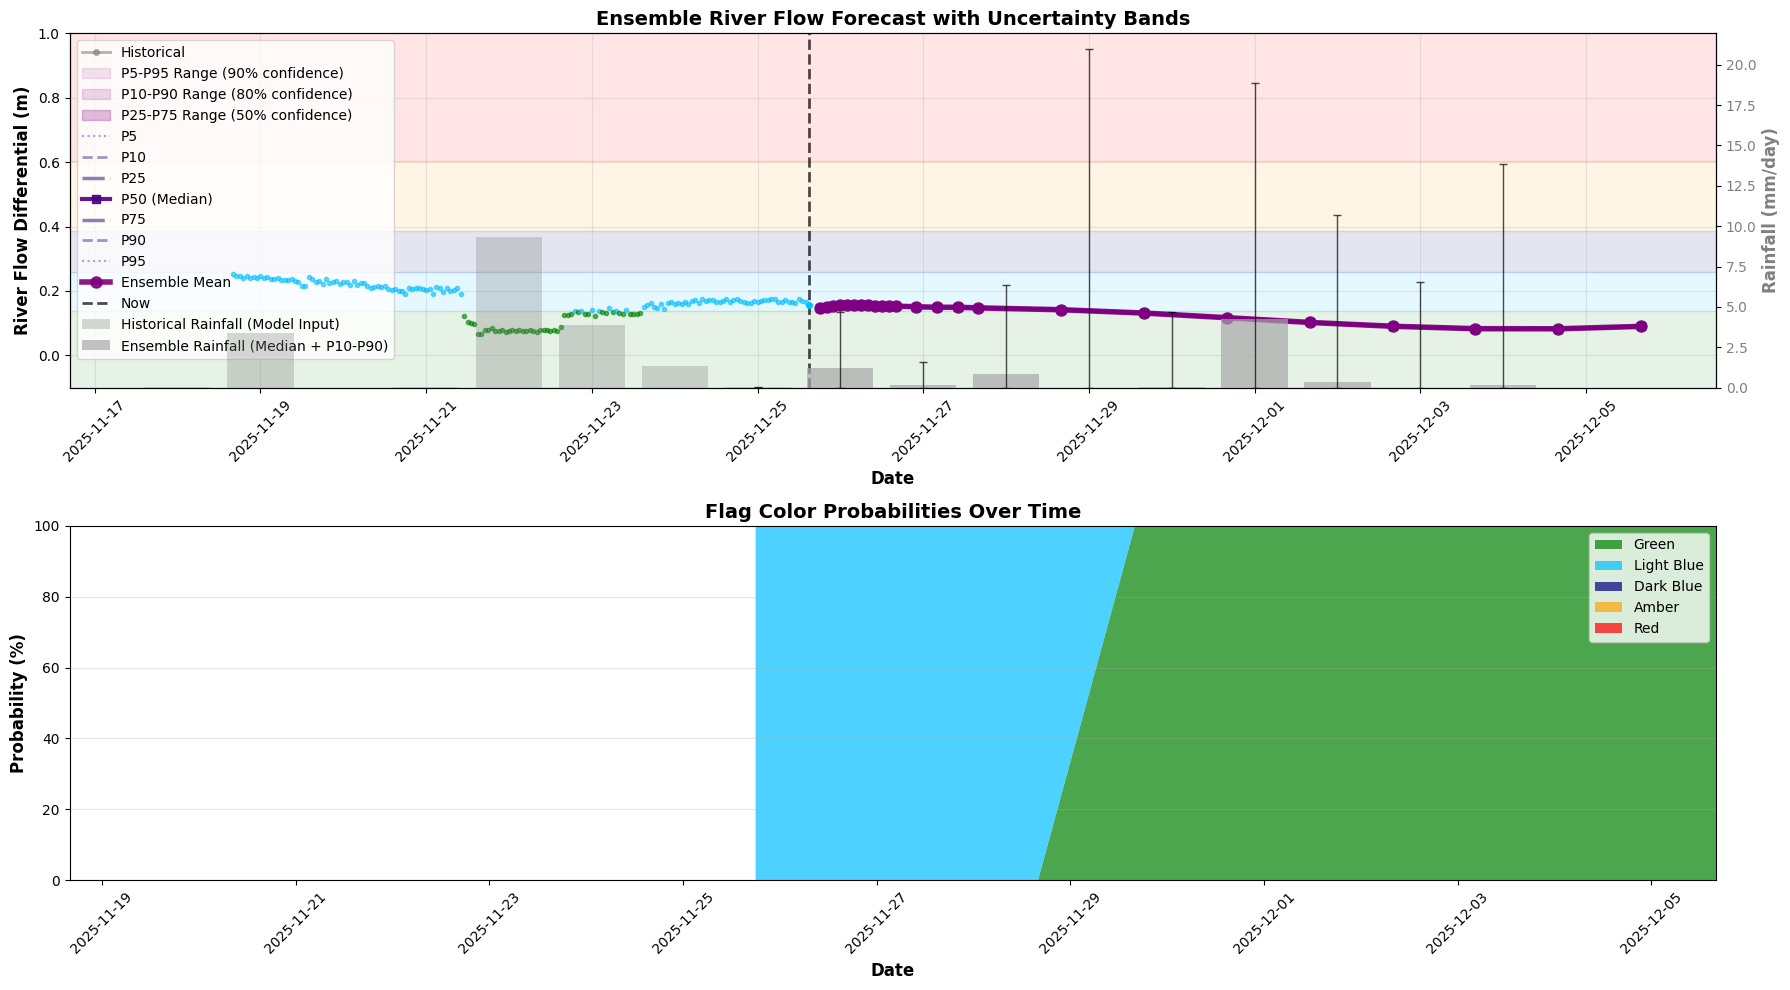


✓ Ensemble visualization complete!
  Top: Fan chart showing ensemble percentiles (P5, P10, P25, P50, P75, P90, P95)
       with uncertainty bands (P5-P95, P10-P90, P25-P75)
  Bottom: Flag color probabilities over time


In [34]:
# Step 5: Visualize Ensemble Forecast with Uncertainty
print("\n" + "="*80)
print("STEP 5: Visualizing Ensemble Forecast")
print("="*80)

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# ============== Top Plot: Ensemble Forecast Fan Chart ==============
ax = axes[0]
ax_twin = ax.twinx()  # Create twin axis for rainfall

# Prepare data (timezone naive for plotting)
last_7_days = isis_df_featureless.iloc[-24*7:].copy()
if hasattr(last_7_days.index, 'tz') and last_7_days.index.tz is not None:
    last_7_days.index = last_7_days.index.tz_localize(None)

# Prepare ensemble forecast timeline
future_timeline_ensemble_plot = pd.Series(
    future_timeline_ensemble_series.values, 
    index=future_timeline_ensemble_series.index.tz_localize(None) if hasattr(future_timeline_ensemble_series.index, 'tz') and future_timeline_ensemble_series.index.tz is not None else future_timeline_ensemble_series.index
)

# Prepare percentile series for plotting
future_timeline_p05 = {}
future_timeline_p10 = {}
future_timeline_p25 = {}
future_timeline_p50 = {}
future_timeline_p75 = {}
future_timeline_p90 = {}
future_timeline_p95 = {}

for horizon in horizons:
    future_time = start_time + pd.Timedelta(hours=horizon)
    if hasattr(future_time, 'tz') and future_time.tz is not None:
        future_time = future_time.tz_localize(None)
    future_timeline_p05[future_time] = ensemble_stats[horizon]['p05'].iloc[first_prediction_idx]
    future_timeline_p10[future_time] = ensemble_stats[horizon]['p10'].iloc[first_prediction_idx]
    future_timeline_p25[future_time] = ensemble_stats[horizon]['p25'].iloc[first_prediction_idx]
    future_timeline_p50[future_time] = ensemble_stats[horizon]['median'].iloc[first_prediction_idx]
    future_timeline_p75[future_time] = ensemble_stats[horizon]['p75'].iloc[first_prediction_idx]
    future_timeline_p90[future_time] = ensemble_stats[horizon]['p90'].iloc[first_prediction_idx]
    future_timeline_p95[future_time] = ensemble_stats[horizon]['p95'].iloc[first_prediction_idx]

p05_series = pd.Series(future_timeline_p05).sort_index()
p10_series = pd.Series(future_timeline_p10).sort_index()
p25_series = pd.Series(future_timeline_p25).sort_index()
p50_series = pd.Series(future_timeline_p50).sort_index()
p75_series = pd.Series(future_timeline_p75).sort_index()
p90_series = pd.Series(future_timeline_p90).sort_index()
p95_series = pd.Series(future_timeline_p95).sort_index()

# Define flag colors
flag_colors = {
    'green': '#008001',
    'light_blue': '#02bfff',
    'dark_blue': '#000080',
    'amber': '#ffa503',
    'red': '#ff0000'
}

def get_flag_color(value):
    if value >= 0.6047:
        return flag_colors['red']
    elif value >= 0.387:
        return flag_colors['amber']
    elif value >= 0.2582:
        return flag_colors['dark_blue']
    elif value >= 0.1366:
        return flag_colors['light_blue']
    else:
        return flag_colors['green']

# Plot flag boundaries as filled regions
# Get the full x-axis range (historical + forecast)
x_min = last_7_days.index[0]
x_max = future_timeline_ensemble_plot.index[-1]

# Add flag boundaries as horizontal filled regions
ax.axhspan(-4, 0.1366, color=flag_colors['green'], alpha=0.1, zorder=0)
ax.axhspan(0.1366, 0.2582, color=flag_colors['light_blue'], alpha=0.1, zorder=0)
ax.axhspan(0.2582, 0.387, color=flag_colors['dark_blue'], alpha=0.1, zorder=0)
ax.axhspan(0.387, 0.6047, color=flag_colors['amber'], alpha=0.1, zorder=0)
ax.axhspan(0.6047, 4, color=flag_colors['red'], alpha=0.1, zorder=0)

# Plot historical data
for i in range(len(last_7_days) - 1):
    value = last_7_days['differential'].iloc[i]
    time = last_7_days.index[i]
    color = get_flag_color(value)
    ax.plot(time, value, marker='o', markersize=3, color=color, zorder=10, alpha=0.6)

last_value = last_7_days['differential'].iloc[-1]
last_time = last_7_days.index[-1]
ax.plot(last_time, last_value, marker='o', markersize=4, color=get_flag_color(last_value), zorder=10)
ax.plot([], [], label='Historical', color='gray', linewidth=2, marker='o', markersize=4, alpha=0.6)

# Plot ensemble percentiles as individual lines
print(f"Plotting ensemble percentiles (P5, P10, P25, P50, P75, P90, P95)...")

# Plot uncertainty bands first (as filled regions)
ax.fill_between(p05_series.index, p05_series.values, p95_series.values, 
               alpha=0.1, color='purple', label='P5-P95 Range (90% confidence)', zorder=3)
ax.fill_between(p10_series.index, p10_series.values, p90_series.values, 
               alpha=0.15, color='purple', label='P10-P90 Range (80% confidence)', zorder=4)
ax.fill_between(p25_series.index, p25_series.values, p75_series.values, 
               alpha=0.25, color='purple', label='P25-P75 Range (50% confidence)', zorder=5)

# Plot percentile lines
ax.plot(p05_series.index, p05_series.values, 
       color='#9370DB', linewidth=1.5, linestyle=':', alpha=0.7, label='P5', zorder=6)
ax.plot(p10_series.index, p10_series.values, 
       color='#8B7AB8', linewidth=2, linestyle='--', alpha=0.8, label='P10', zorder=7)
ax.plot(p25_series.index, p25_series.values, 
       color='#7B68A6', linewidth=2.5, linestyle='-.', alpha=0.85, label='P25', zorder=8)
ax.plot(p50_series.index, p50_series.values, 
       color='#4B0082', linewidth=3, linestyle='-', alpha=0.9, label='P50 (Median)', zorder=9, marker='s', markersize=6)
ax.plot(p75_series.index, p75_series.values, 
       color='#7B68A6', linewidth=2.5, linestyle='-.', alpha=0.85, label='P75', zorder=8)
ax.plot(p90_series.index, p90_series.values, 
       color='#8B7AB8', linewidth=2, linestyle='--', alpha=0.8, label='P90', zorder=7)
ax.plot(p95_series.index, p95_series.values, 
       color='#9370DB', linewidth=1.5, linestyle=':', alpha=0.7, label='P95', zorder=6)

# Plot ensemble mean
ax.plot(future_timeline_ensemble_plot.index, future_timeline_ensemble_plot.values, 
       color='purple', linewidth=4, marker='o', markersize=8, 
       label='Ensemble Mean', zorder=11, alpha=0.9)


# Current time marker
current_time = last_7_days.index[-1]
ax.axvline(x=current_time, color='black', linestyle='--', linewidth=2, 
          alpha=0.7, label='Now', zorder=2)

# Add rainfall data
rainfall_cols = [col for col in isis_df_featureless.columns if col != 'differential']

# Historical rainfall
hist_start_time = isis_df_featureless.index[-24*7]
hist_end_time = isis_df_featureless.index[-1]
historical_rainfall_data = isis_df_featureless.loc[hist_start_time:hist_end_time, rainfall_cols]

if hasattr(historical_rainfall_data.index, 'tz') and historical_rainfall_data.index.tz is not None:
    historical_rainfall_data.index = historical_rainfall_data.index.tz_localize(None)

historical_rainfall_avg = historical_rainfall_data.mean(axis=1)
daily_historical_rainfall = historical_rainfall_avg.resample('1D').sum()

# Forecast rainfall - Calculate ensemble spread
# Extract rainfall data for all ensemble members
rainfall_forecast_df_naive = rainfall_forecast_all_members.copy()
if hasattr(rainfall_forecast_df_naive.index, 'tz') and rainfall_forecast_df_naive.index.tz is not None:
    rainfall_forecast_df_naive.index = rainfall_forecast_df_naive.index.tz_localize(None)

# For each station, calculate median and percentiles across all members
station_names_list = list(station_coordinates.keys())
n_members = len([col for col in rainfall_forecast_all_members.columns if col.startswith(f'{station_names_list[0]}_member_')])

# Calculate statistics for each station
ensemble_rainfall_stats = {'median': [], 'p10': [], 'p90': []}

for station in station_names_list:
    # Get all member columns for this station
    member_cols = [f'{station}_member_{i}' for i in range(n_members)]
    member_data = rainfall_forecast_df_naive[member_cols]
    
    # Calculate median and percentiles across members (axis=1 for each timestamp)
    ensemble_rainfall_stats['median'].append(member_data.median(axis=1))
    ensemble_rainfall_stats['p10'].append(member_data.quantile(0.1, axis=1))
    ensemble_rainfall_stats['p90'].append(member_data.quantile(0.9, axis=1))

# Average across all stations
ensemble_median = pd.concat(ensemble_rainfall_stats['median'], axis=1).mean(axis=1)
ensemble_p10 = pd.concat(ensemble_rainfall_stats['p10'], axis=1).mean(axis=1)
ensemble_p90 = pd.concat(ensemble_rainfall_stats['p90'], axis=1).mean(axis=1)

# Resample to daily
daily_rainfall_median = ensemble_median.resample('1D').sum()
daily_rainfall_p10 = ensemble_p10.resample('1D').sum()
daily_rainfall_p90 = ensemble_p90.resample('1D').sum()

# Calculate error bars (distance from median to percentiles)
daily_rainfall_error_lower = daily_rainfall_median - daily_rainfall_p10
daily_rainfall_error_upper = daily_rainfall_p90 - daily_rainfall_median

# Plot rainfall bars
ax_twin.bar(daily_historical_rainfall.index, daily_historical_rainfall.values,
           color='gray', alpha=0.3, width=0.8, label='Historical Rainfall (Model Input)', zorder=1)

# Plot ensemble rainfall with error bars
ax_twin.bar(daily_rainfall_median.index, daily_rainfall_median.values, 
           color='darkgray', alpha=0.7, width=0.8, 
           yerr=[daily_rainfall_error_lower.values, daily_rainfall_error_upper.values],
           error_kw={'elinewidth': 1, 'capsize': 3, 'capthick': 1, 'alpha': 0.7},
           label='Ensemble Rainfall (Median + P10-P90)', zorder=1)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('River Flow Differential (m)', fontsize=12, fontweight='bold')
ax_twin.set_ylabel('Rainfall (mm/day)', fontsize=12, fontweight='bold', color='gray')
ax_twin.tick_params(axis='y', labelcolor='gray')
ax_twin.set_ylim(0, max(daily_rainfall_p90.values) + 1)
ax.set_title('Ensemble River Flow Forecast with Uncertainty Bands', 
          fontsize=14, fontweight='bold')

# Combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='upper left')

ax.grid(True, alpha=0.3)
ax.set_ylim(-0.1, 1.0)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)


# ============== Bottom Plot: Flag Probabilities Over Time ==============
ax3 = axes[1]

# Extract flag probabilities at each forecast time
flag_prob_timeline = {flag: [] for flag in FLAG_BOUNDARIES.keys()}
times = []

for horizon in horizons:
    future_time = start_time + pd.Timedelta(hours=horizon)
    if hasattr(future_time, 'tz') and future_time.tz is not None:
        future_time = future_time.tz_localize(None)
    times.append(future_time)
    
    for flag in FLAG_BOUNDARIES.keys():
        flag_prob_timeline[flag].append(flag_probabilities[horizon][flag].iloc[first_prediction_idx])

# Create stacked area plot
ax3.stackplot(times,
             flag_prob_timeline['green'],
             flag_prob_timeline['light_blue'],
             flag_prob_timeline['dark_blue'],
             flag_prob_timeline['amber'],
             flag_prob_timeline['red'],
             labels=['Green', 'Light Blue', 'Dark Blue', 'Amber', 'Red'],
             colors=[flag_colors['green'], flag_colors['light_blue'], 
                    flag_colors['dark_blue'], flag_colors['amber'], flag_colors['red']],
             alpha=0.7)

# Set the same x-axis limits as the top plot
ax3.set_xlim(x_min, x_max)

ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.set_ylabel('Probability (%)', fontsize=12, fontweight='bold')
ax3.set_title('Flag Color Probabilities Over Time', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 100)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Ensemble visualization complete!")
print(f"  Top: Fan chart showing ensemble percentiles (P5, P10, P25, P50, P75, P90, P95)")
print(f"       with uncertainty bands (P5-P95, P10-P90, P25-P75)")
print(f"  Bottom: Flag color probabilities over time")



STEP 6: Creating Spaghetti Plot
Plotting ensemble percentiles (P5, P10, P25, P50, P75, P90, P95)...


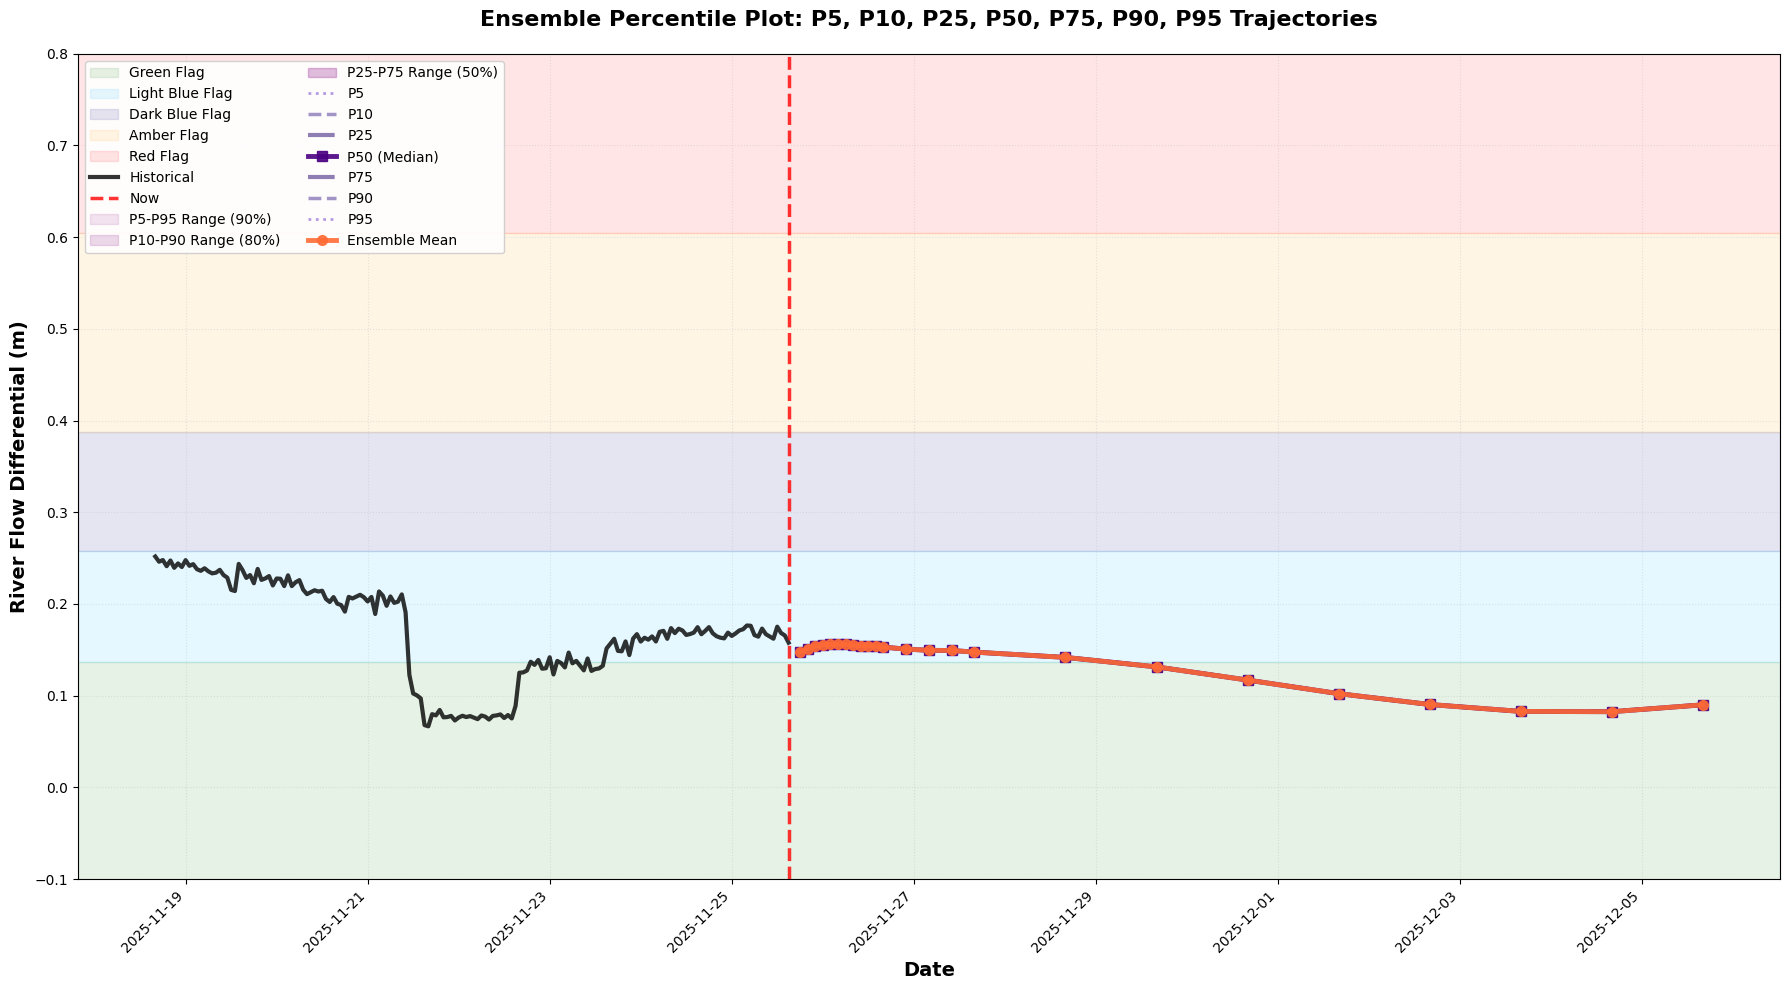


✓ Ensemble percentile plot complete!
  Shows ensemble forecast percentiles: P5, P10, P25, P50 (median), P75, P90, P95
  Uncertainty bands: P5-P95 (90%), P10-P90 (80%), P25-P75 (50%)
  Orange line = ensemble mean for comparison with P50 (median)


In [35]:
# Step 6: Spaghetti Plot - All Ensemble Members
print("\n" + "="*80)
print("STEP 6: Creating Spaghetti Plot")
print("="*80)

fig, ax = plt.subplots(figsize=(18, 10))

# Define flag colors
flag_colors = {
    'green': '#008001',
    'light_blue': '#02bfff',
    'dark_blue': '#000080',
    'amber': '#ffa503',
    'red': '#ff0000'
}

# Add flag boundaries as horizontal filled regions
ax.axhspan(-4, 0.1366, color=flag_colors['green'], alpha=0.1, zorder=0, label='Green Flag')
ax.axhspan(0.1366, 0.2582, color=flag_colors['light_blue'], alpha=0.1, zorder=0, label='Light Blue Flag')
ax.axhspan(0.2582, 0.387, color=flag_colors['dark_blue'], alpha=0.1, zorder=0, label='Dark Blue Flag')
ax.axhspan(0.387, 0.6047, color=flag_colors['amber'], alpha=0.1, zorder=0, label='Amber Flag')
ax.axhspan(0.6047, 4, color=flag_colors['red'], alpha=0.1, zorder=0, label='Red Flag')

# Prepare historical data (last 7 days)
last_7_days = isis_df_featureless.iloc[-24*7:].copy()
if hasattr(last_7_days.index, 'tz') and last_7_days.index.tz is not None:
    last_7_days.index = last_7_days.index.tz_localize(None)

# Plot historical data as a solid black line
ax.plot(last_7_days.index, last_7_days['differential'].values, 
        color='black', linewidth=3, label='Historical', zorder=100, alpha=0.8)

# Current time marker
current_time = last_7_days.index[-1]
ax.axvline(x=current_time, color='red', linestyle='--', linewidth=2.5, 
          alpha=0.8, label='Now', zorder=101)

# Plot ensemble percentiles instead of individual members
print(f"Plotting ensemble percentiles (P5, P10, P25, P50, P75, P90, P95)...")

# Calculate percentile series for each horizon
percentile_timelines = {
    'p05': {}, 'p10': {}, 'p25': {}, 'p50': {},
    'p75': {}, 'p90': {}, 'p95': {}
}

for horizon in horizons:
    future_time = start_time + pd.Timedelta(hours=horizon)
    if hasattr(future_time, 'tz') and future_time.tz is not None:
        future_time = future_time.tz_localize(None)
    
    percentile_timelines['p05'][future_time] = ensemble_stats[horizon]['p05'].iloc[first_prediction_idx]
    percentile_timelines['p10'][future_time] = ensemble_stats[horizon]['p10'].iloc[first_prediction_idx]
    percentile_timelines['p25'][future_time] = ensemble_stats[horizon]['p25'].iloc[first_prediction_idx]
    percentile_timelines['p50'][future_time] = ensemble_stats[horizon]['median'].iloc[first_prediction_idx]
    percentile_timelines['p75'][future_time] = ensemble_stats[horizon]['p75'].iloc[first_prediction_idx]
    percentile_timelines['p90'][future_time] = ensemble_stats[horizon]['p90'].iloc[first_prediction_idx]
    percentile_timelines['p95'][future_time] = ensemble_stats[horizon]['p95'].iloc[first_prediction_idx]

# Convert to series
p05_spaghetti = pd.Series(percentile_timelines['p05']).sort_index()
p10_spaghetti = pd.Series(percentile_timelines['p10']).sort_index()
p25_spaghetti = pd.Series(percentile_timelines['p25']).sort_index()
p50_spaghetti = pd.Series(percentile_timelines['p50']).sort_index()
p75_spaghetti = pd.Series(percentile_timelines['p75']).sort_index()
p90_spaghetti = pd.Series(percentile_timelines['p90']).sort_index()
p95_spaghetti = pd.Series(percentile_timelines['p95']).sort_index()

# Plot uncertainty bands
ax.fill_between(p05_spaghetti.index, p05_spaghetti.values, p95_spaghetti.values, 
               alpha=0.1, color='purple', label='P5-P95 Range (90%)', zorder=40)
ax.fill_between(p10_spaghetti.index, p10_spaghetti.values, p90_spaghetti.values, 
               alpha=0.15, color='purple', label='P10-P90 Range (80%)', zorder=41)
ax.fill_between(p25_spaghetti.index, p25_spaghetti.values, p75_spaghetti.values, 
               alpha=0.25, color='purple', label='P25-P75 Range (50%)', zorder=42)

# Plot percentile lines
ax.plot(p05_spaghetti.index, p05_spaghetti.values, 
       color='#9370DB', linewidth=2, linestyle=':', alpha=0.7, label='P5', zorder=50)
ax.plot(p10_spaghetti.index, p10_spaghetti.values, 
       color='#8B7AB8', linewidth=2.5, linestyle='--', alpha=0.8, label='P10', zorder=51)
ax.plot(p25_spaghetti.index, p25_spaghetti.values, 
       color='#7B68A6', linewidth=3, linestyle='-.', alpha=0.85, label='P25', zorder=52)
ax.plot(p50_spaghetti.index, p50_spaghetti.values, 
       color='#4B0082', linewidth=3.5, linestyle='-', marker='s', markersize=7,
       alpha=0.9, label='P50 (Median)', zorder=53)
ax.plot(p75_spaghetti.index, p75_spaghetti.values, 
       color='#7B68A6', linewidth=3, linestyle='-.', alpha=0.85, label='P75', zorder=52)
ax.plot(p90_spaghetti.index, p90_spaghetti.values, 
       color='#8B7AB8', linewidth=2.5, linestyle='--', alpha=0.8, label='P90', zorder=51)
ax.plot(p95_spaghetti.index, p95_spaghetti.values, 
       color='#9370DB', linewidth=2, linestyle=':', alpha=0.7, label='P95', zorder=50)

# Optionally overlay the ensemble MEAN as a bold line (for comparison with median/P50)
future_timeline_ensemble_plot = pd.Series(
    future_timeline_ensemble_series.values, 
    index=future_timeline_ensemble_series.index.tz_localize(None) if hasattr(future_timeline_ensemble_series.index, 'tz') and future_timeline_ensemble_series.index.tz is not None else future_timeline_ensemble_series.index
)

ax.plot(future_timeline_ensemble_plot.index, future_timeline_ensemble_plot.values, 
       color='#FF6B35', linewidth=3.5, marker='o', markersize=7, 
       label='Ensemble Mean', zorder=102, alpha=0.9)

# Formatting
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('River Flow Differential (m)', fontsize=14, fontweight='bold')
ax.set_title('Ensemble Percentile Plot: P5, P10, P25, P50, P75, P90, P95 Trajectories', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(-0.1, 0.8)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax.legend(fontsize=10, loc='upper left', framealpha=0.9, ncol=2)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✓ Ensemble percentile plot complete!")
print(f"  Shows ensemble forecast percentiles: P5, P10, P25, P50 (median), P75, P90, P95")
print(f"  Uncertainty bands: P5-P95 (90%), P10-P90 (80%), P25-P75 (50%)")
print(f"  Orange line = ensemble mean for comparison with P50 (median)")


In [36]:
# Step 7: Backtest - Compare Actual vs 24h-Ahead Predictions
print("\n" + "="*80)
print("STEP 7: Generating Backtest Plot - Actual vs 24h-Ahead Predictions")
print("="*80)

def create_backtest_predictions(model, scaler, historical_df, X_train_columns, 
                                 sequence_length, horizons, horizon_to_plot=24):
    """
    Create predictions for each historical timestamp, showing what the model
    would have predicted 24 hours earlier.
    
    For each timestamp T, we predict what the differential will be at T using
    data from T-24 hours.
    """
    print(f"Generating {horizon_to_plot}h-ahead predictions for historical data...")
    
    # We need enough history for both sequence_length and the prediction horizon
    lookback_hours = 720  # 30 days for features
    start_idx = lookback_hours + sequence_length + horizon_to_plot
    
    # Use Sep-Oct 2024 for backtest visualization
    # Find the start of September 2024 in the data
    sep_2024_start = pd.Timestamp('2024-09-01', tz=historical_df.index.tz)
    oct_2024_end = pd.Timestamp('2024-10-31 23:59:59', tz=historical_df.index.tz)
    
    try:
        start_2024_idx = historical_df.index.get_indexer([sep_2024_start], method='nearest')[0]
    except:
        start_2024_idx = 0
    
    try:
        end_2024_idx = historical_df.index.get_indexer([oct_2024_end], method='nearest')[0]
    except:
        end_2024_idx = len(historical_df)
    
    end_idx = min(len(historical_df), end_2024_idx + 1)
    start_idx = max(start_idx, start_2024_idx)
    
    # Sample once per day at 12:00 (noon) for faster computation
    # Find all timestamps at 12:00
    daily_indices = []
    for i in range(start_idx, end_idx):
        timestamp = historical_df.index[i]
        if timestamp.hour == 12:
            daily_indices.append(i)
    
    print(f"Sampling once per day at 12:00 - {len(daily_indices)} predictions...")
    
    predictions = []
    actuals = []
    timestamps = []
    
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(daily_indices, desc="Backtesting"):
            # At timestamp i, we want to predict what differential will be at i
            # So we use data from up to (i - horizon_to_plot) hours
            prediction_time = i - horizon_to_plot
            
            # Check we have enough history
            if prediction_time < sequence_length:
                continue
            
            # Create features for the historical data up to prediction_time
            # We need to simulate what features would have been available then
            history_slice = historical_df.iloc[:prediction_time + 1].copy()
            
            # Create features (but WITHOUT future rainfall since we're at prediction_time)
            # We'll use the actual historical rainfall that occurred after prediction_time
            rainfall_cols = [col for col in history_slice.columns if col != 'differential']
            
            # For backtesting, we use the ACTUAL rainfall that occurred 
            # (this simulates having a perfect forecast)
            actual_future_rainfall = historical_df.iloc[prediction_time:i + 1][rainfall_cols].copy()
            
            # Create features
            try:
                df_with_features = create_features_with_future_rainfall(
                    history_slice,
                    actual_future_rainfall,
                    differential_column='differential'
                )
                
                # Get features at prediction_time
                X_current = df_with_features[X_train_columns].iloc[-1:].copy()
                
                # Need a sequence
                if len(df_with_features) < sequence_length:
                    continue
                    
                X_sequence = df_with_features[X_train_columns].iloc[-sequence_length:].copy()
                
                # Clean
                X_sequence = X_sequence.ffill().bfill().fillna(0)
                
                # Scale and predict
                X_scaled = scaler.transform(X_sequence)
                X_tensor = torch.FloatTensor(X_scaled).unsqueeze(0).to(device)
                
                # Predict all horizons
                predictions_all = model(X_tensor).cpu().numpy()[0]
                
                # Get the prediction for our target horizon
                horizon_idx = horizons.index(horizon_to_plot)
                pred_value = predictions_all[horizon_idx]
                
                # Get actual value
                actual_value = historical_df['differential'].iloc[i]
                
                # Store results
                predictions.append(pred_value)
                actuals.append(actual_value)
                timestamps.append(historical_df.index[i])
                
            except Exception as e:
                continue
    
    # Create DataFrame
    backtest_df = pd.DataFrame({
        'timestamp': timestamps,
        f'predicted_{horizon_to_plot}h_ahead': predictions,
        'actual': actuals
    })
    backtest_df.set_index('timestamp', inplace=True)
    
    # Calculate errors
    backtest_df['error'] = backtest_df['actual'] - backtest_df[f'predicted_{horizon_to_plot}h_ahead']
    backtest_df['abs_error'] = np.abs(backtest_df['error'])
    
    mae = backtest_df['abs_error'].mean()
    rmse = np.sqrt((backtest_df['error'] ** 2).mean())
    
    print(f"\n✓ Backtest complete!")
    print(f"  Timestamps: {len(backtest_df)}")
    print(f"  MAE: {mae:.4f}m")
    print(f"  RMSE: {rmse:.4f}m")
    
    return backtest_df

# Generate backtest predictions
backtest_df = create_backtest_predictions(
    model=best_model,
    scaler=scaler,
    historical_df=isis_df_featureless,
    X_train_columns=X_isis.columns,
    sequence_length=sequence_length,
    horizons=horizons,
    horizon_to_plot=24  # 24 hours ahead
)

print("\n" + "="*80)
print("PLOTTING ACTUAL vs PREDICTED")
print("="*80)



STEP 7: Generating Backtest Plot - Actual vs 24h-Ahead Predictions
Generating 24h-ahead predictions for historical data...
Sampling once per day at 12:00 - 59 predictions...


Backtesting: 100%|██████████| 59/59 [02:30<00:00,  2.55s/it]


✓ Backtest complete!
  Timestamps: 59
  MAE: 0.0621m
  RMSE: 0.0929m

PLOTTING ACTUAL vs PREDICTED


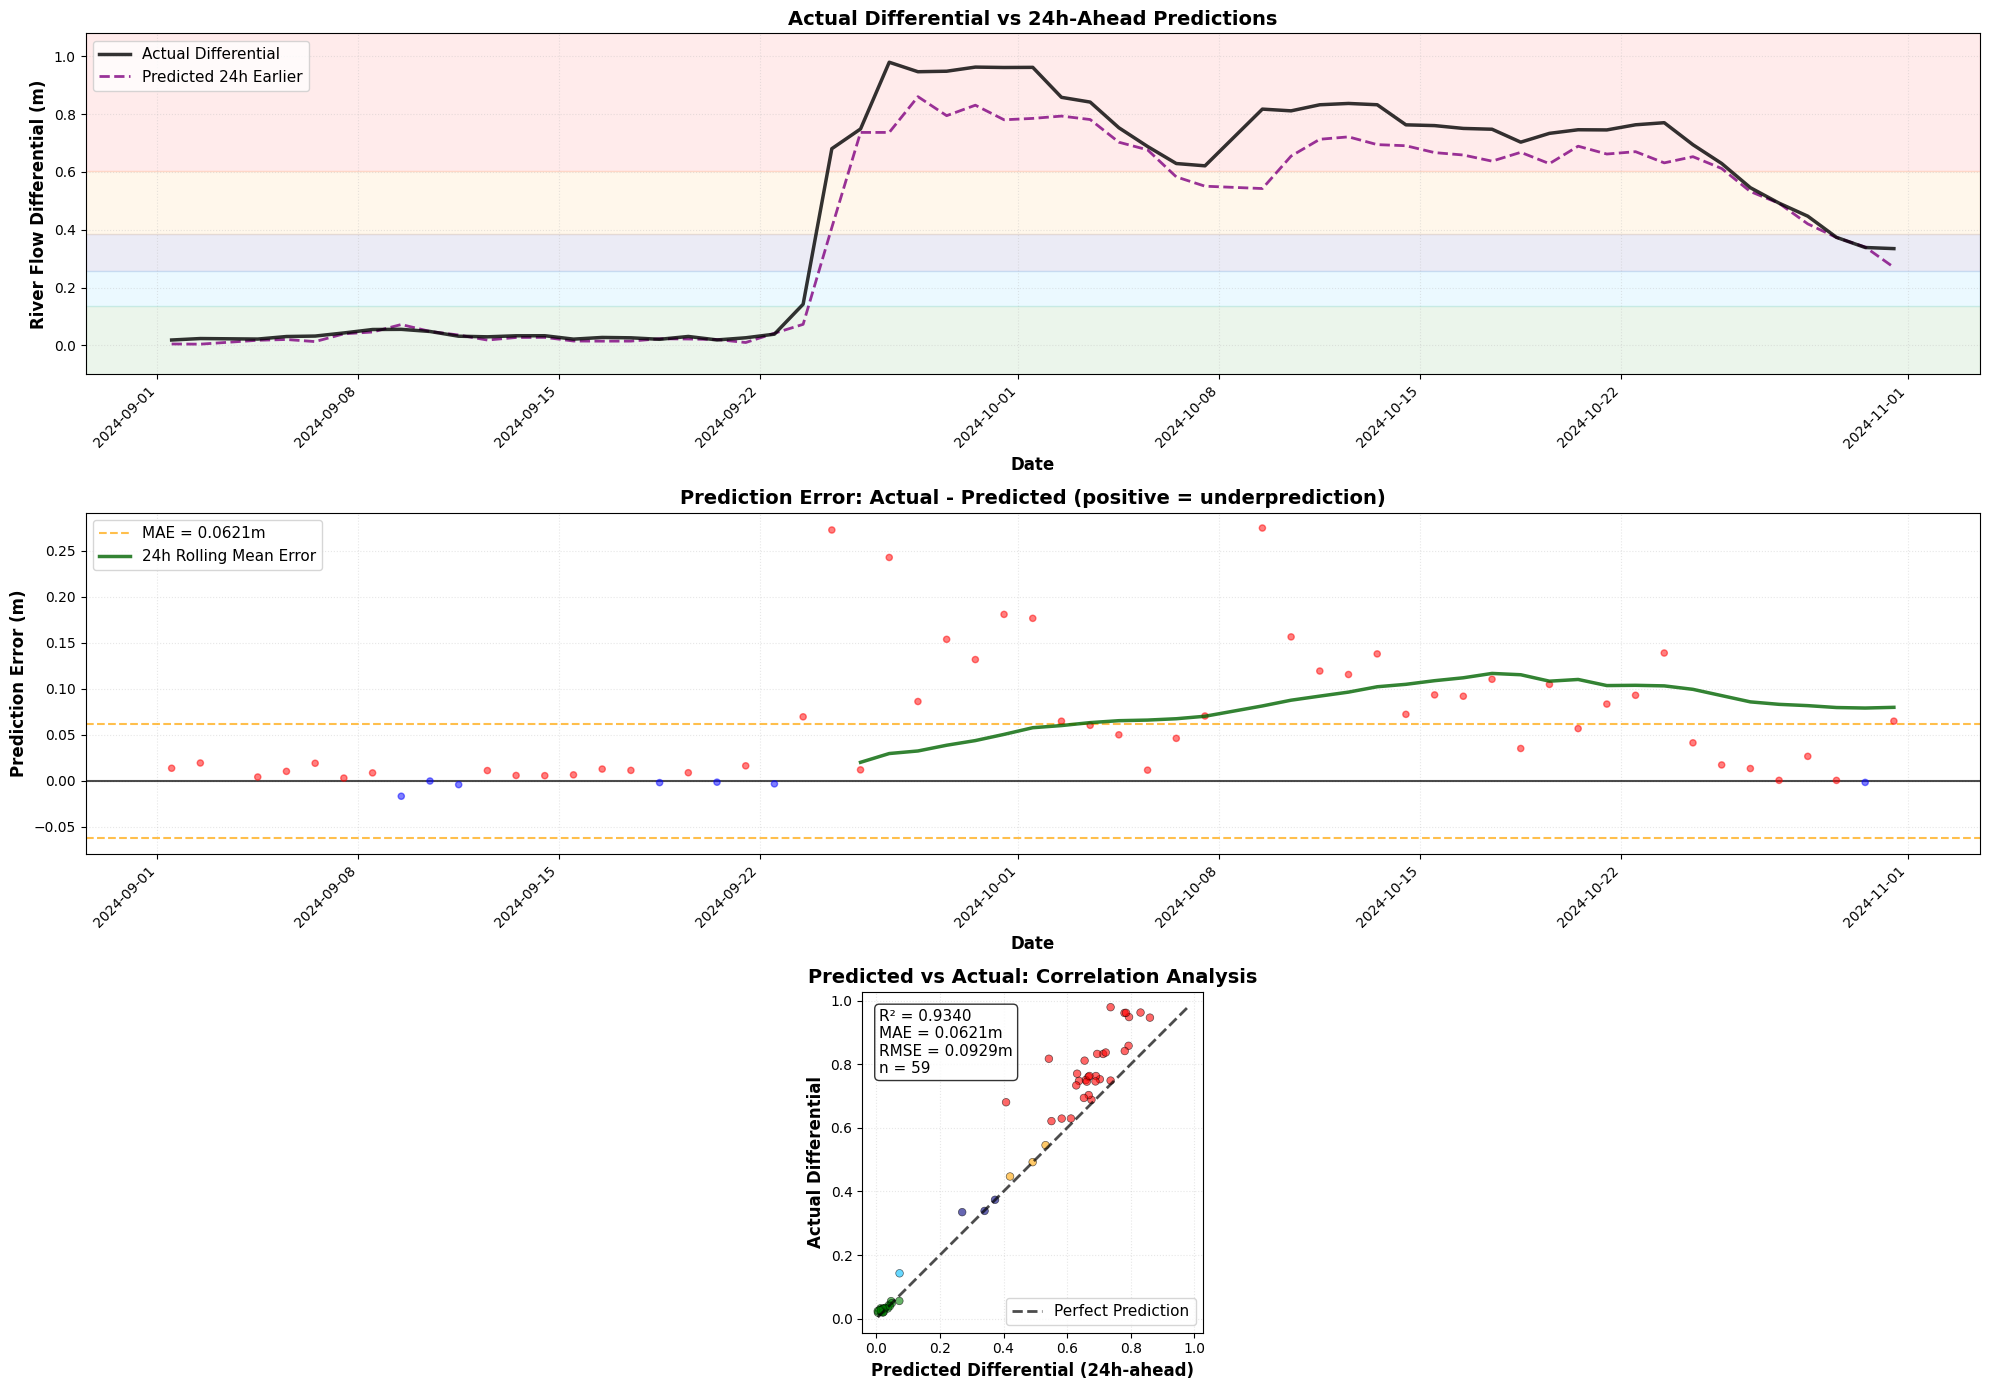


✓ Backtest visualization complete!

Key Metrics:
  R² Score: 0.9340
  MAE: 0.0621m
  RMSE: 0.0929m
  Mean Error (bias): 0.0611m
  Std Error: 0.0705m


In [37]:
# Plot Actual vs 24h-Ahead Predictions
fig, axes = plt.subplots(3, 1, figsize=(20, 14))

# Define flag colors
flag_colors = {
    'green': '#008001',
    'light_blue': '#02bfff',
    'dark_blue': '#000080',
    'amber': '#ffa503',
    'red': '#ff0000'
}

# Prepare data (make timezone naive if needed)
plot_df = backtest_df.copy()
if hasattr(plot_df.index, 'tz') and plot_df.index.tz is not None:
    plot_df.index = plot_df.index.tz_localize(None)

# ============== Plot 1: Actual vs Predicted Time Series ==============
ax1 = axes[0]

# Add flag boundaries
ax1.axhspan(-4, 0.1366, color=flag_colors['green'], alpha=0.08, zorder=0)
ax1.axhspan(0.1366, 0.2582, color=flag_colors['light_blue'], alpha=0.08, zorder=0)
ax1.axhspan(0.2582, 0.387, color=flag_colors['dark_blue'], alpha=0.08, zorder=0)
ax1.axhspan(0.387, 0.6047, color=flag_colors['amber'], alpha=0.08, zorder=0)
ax1.axhspan(0.6047, 4, color=flag_colors['red'], alpha=0.08, zorder=0)

# Plot actual differential
ax1.plot(plot_df.index, plot_df['actual'], 
        color='black', linewidth=2.5, label='Actual Differential', 
        zorder=10, alpha=0.8)

# Plot predicted differential (what was predicted 24h earlier)
ax1.plot(plot_df.index, plot_df['predicted_24h_ahead'], 
        color='purple', linewidth=2, label='Predicted 24h Earlier', 
        linestyle='--', zorder=9, alpha=0.8)

ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('River Flow Differential (m)', fontsize=12, fontweight='bold')
ax1.set_title('Actual Differential vs 24h-Ahead Predictions', 
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax1.set_ylim(-0.1, max(plot_df['actual'].max(), plot_df['predicted_24h_ahead'].max()) + 0.1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ============== Plot 2: Prediction Error Over Time ==============
ax2 = axes[1]

# Plot error (positive = underprediction, negative = overprediction)
colors = ['red' if e > 0 else 'blue' for e in plot_df['error']]
ax2.scatter(plot_df.index, plot_df['error'], 
           c=colors, alpha=0.5, s=20, zorder=10)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)

# Add error bands
mae = plot_df['abs_error'].mean()
ax2.axhline(y=mae, color='orange', linestyle='--', linewidth=1.5, 
           label=f'MAE = {mae:.4f}m', alpha=0.7)
ax2.axhline(y=-mae, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)

# Rolling mean error
rolling_error = plot_df['error'].rolling(window=24).mean()
ax2.plot(plot_df.index, rolling_error, 
        color='darkgreen', linewidth=2.5, 
        label='24h Rolling Mean Error', zorder=11, alpha=0.8)

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Prediction Error (m)', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Error: Actual - Predicted (positive = underprediction)', 
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ============== Plot 3: Scatter Plot - Actual vs Predicted ==============
ax3 = axes[2]

# Color points by actual flag color
def get_flag_color(value):
    if value >= 0.6047:
        return flag_colors['red']
    elif value >= 0.387:
        return flag_colors['amber']
    elif value >= 0.2582:
        return flag_colors['dark_blue']
    elif value >= 0.1366:
        return flag_colors['light_blue']
    else:
        return flag_colors['green']

point_colors = [get_flag_color(v) for v in plot_df['actual']]

ax3.scatter(plot_df['predicted_24h_ahead'], plot_df['actual'], 
           c=point_colors, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

# Perfect prediction line
min_val = min(plot_df['predicted_24h_ahead'].min(), plot_df['actual'].min())
max_val = max(plot_df['predicted_24h_ahead'].max(), plot_df['actual'].max())
ax3.plot([min_val, max_val], [min_val, max_val], 
        'k--', linewidth=2, label='Perfect Prediction', alpha=0.7)

# Calculate R² 
from sklearn.metrics import r2_score
r2 = r2_score(plot_df['actual'], plot_df['predicted_24h_ahead'])
mae = plot_df['abs_error'].mean()
rmse = np.sqrt((plot_df['error'] ** 2).mean())

# Add statistics text box
stats_text = f'R² = {r2:.4f}\nMAE = {mae:.4f}m\nRMSE = {rmse:.4f}m\nn = {len(plot_df)}'
ax3.text(0.05, 0.95, stats_text, transform=ax3.transAxes, 
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_xlabel('Predicted Differential (24h-ahead)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Actual Differential', fontsize=12, fontweight='bold')
ax3.set_title('Predicted vs Actual: Correlation Analysis', 
             fontsize=14, fontweight='bold')
ax3.legend(fontsize=11, loc='lower right')
ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax3.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print("\n✓ Backtest visualization complete!")
print(f"\nKey Metrics:")
print(f"  R² Score: {r2:.4f}")
print(f"  MAE: {mae:.4f}m")
print(f"  RMSE: {rmse:.4f}m")
print(f"  Mean Error (bias): {plot_df['error'].mean():.4f}m")
print(f"  Std Error: {plot_df['error'].std():.4f}m")


In [38]:
# Step 8: Backtest for 48h-Ahead Predictions
print("\n" + "="*80)
print("STEP 8: Generating 48h-Ahead Backtest")
print("="*80)

# Generate backtest predictions for 48h ahead
backtest_48h_df = create_backtest_predictions(
    model=best_model,
    scaler=scaler,
    historical_df=isis_df_featureless,
    X_train_columns=X_isis.columns,
    sequence_length=sequence_length,
    horizons=horizons,
    horizon_to_plot=48  # 48 hours ahead
)

print("\n" + "="*80)
print("PLOTTING 48h-AHEAD: ACTUAL vs PREDICTED")
print("="*80)



STEP 8: Generating 48h-Ahead Backtest
Generating 48h-ahead predictions for historical data...
Sampling once per day at 12:00 - 59 predictions...


Backtesting: 100%|██████████| 59/59 [02:36<00:00,  2.65s/it]


✓ Backtest complete!
  Timestamps: 59
  MAE: 0.1134m
  RMSE: 0.1657m

PLOTTING 48h-AHEAD: ACTUAL vs PREDICTED


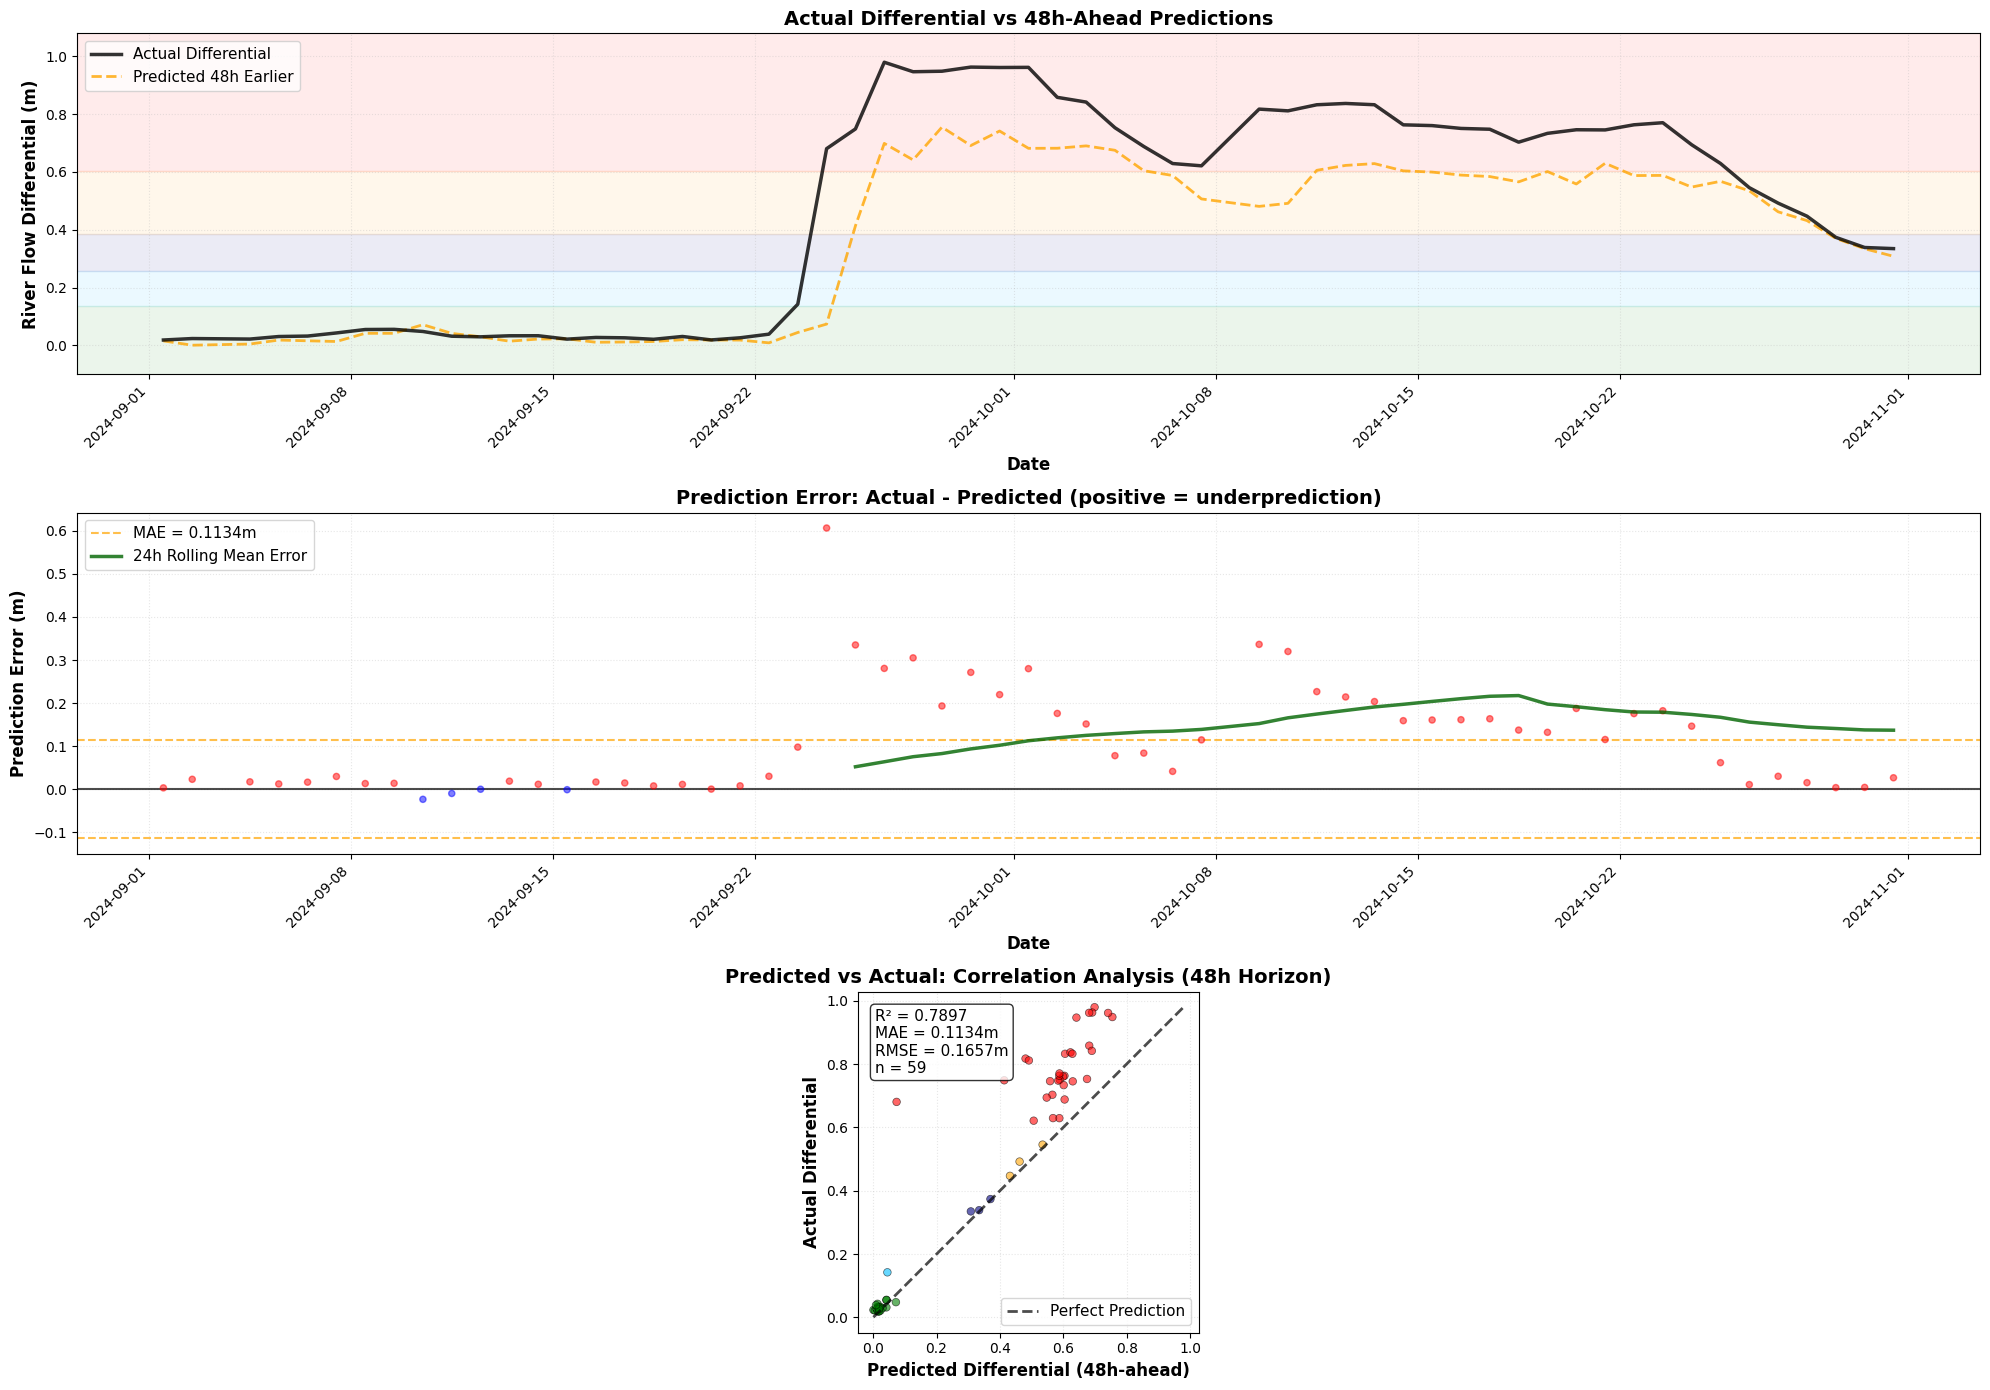


✓ 48h-Ahead Backtest visualization complete!

Key Metrics (48h horizon):
  R² Score: 0.7897
  MAE: 0.1134m
  RMSE: 0.1657m
  Mean Error (bias): 0.1122m
  Std Error: 0.1230m

COMPARISON: 24h vs 48h Ahead Predictions
Metric               24h Ahead       48h Ahead       Difference     
--------------------------------------------------------------------------------
MAE (m)              0.0621          0.1134          +0.0513
RMSE (m)             0.0929          0.1657          +0.0729
R² Score             0.9340          0.7897          -0.1443


In [40]:
# Plot 48h-Ahead: Actual vs Predicted
fig, axes = plt.subplots(3, 1, figsize=(20, 14))

# Define flag colors
flag_colors = {
    'green': '#008001',
    'light_blue': '#02bfff',
    'dark_blue': '#000080',
    'amber': '#ffa503',
    'red': '#ff0000'
}

# Prepare data (make timezone naive if needed)
plot_df = backtest_48h_df.copy()
if hasattr(plot_df.index, 'tz') and plot_df.index.tz is not None:
    plot_df.index = plot_df.index.tz_localize(None)

# ============== Plot 1: Actual vs Predicted Time Series ==============
ax1 = axes[0]

# Add flag boundaries
ax1.axhspan(-4, 0.1366, color=flag_colors['green'], alpha=0.08, zorder=0)
ax1.axhspan(0.1366, 0.2582, color=flag_colors['light_blue'], alpha=0.08, zorder=0)
ax1.axhspan(0.2582, 0.387, color=flag_colors['dark_blue'], alpha=0.08, zorder=0)
ax1.axhspan(0.387, 0.6047, color=flag_colors['amber'], alpha=0.08, zorder=0)
ax1.axhspan(0.6047, 4, color=flag_colors['red'], alpha=0.08, zorder=0)

# Plot actual differential
ax1.plot(plot_df.index, plot_df['actual'], 
        color='black', linewidth=2.5, label='Actual Differential', 
        zorder=10, alpha=0.8)

# Plot predicted differential (what was predicted 48h earlier)
ax1.plot(plot_df.index, plot_df['predicted_48h_ahead'], 
        color='orange', linewidth=2, label='Predicted 48h Earlier', 
        linestyle='--', zorder=9, alpha=0.8)

ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('River Flow Differential (m)', fontsize=12, fontweight='bold')
ax1.set_title('Actual Differential vs 48h-Ahead Predictions', 
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax1.set_ylim(-0.1, max(plot_df['actual'].max(), plot_df['predicted_48h_ahead'].max()) + 0.1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ============== Plot 2: Prediction Error Over Time ==============
ax2 = axes[1]

# Plot error (positive = underprediction, negative = overprediction)
colors = ['red' if e > 0 else 'blue' for e in plot_df['error']]
ax2.scatter(plot_df.index, plot_df['error'], 
           c=colors, alpha=0.5, s=20, zorder=10)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)

# Add error bands
mae = plot_df['abs_error'].mean()
ax2.axhline(y=mae, color='orange', linestyle='--', linewidth=1.5, 
           label=f'MAE = {mae:.4f}m', alpha=0.7)
ax2.axhline(y=-mae, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)

# Rolling mean error
rolling_error = plot_df['error'].rolling(window=24).mean()
ax2.plot(plot_df.index, rolling_error, 
        color='darkgreen', linewidth=2.5, 
        label='24h Rolling Mean Error', zorder=11, alpha=0.8)

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Prediction Error (m)', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Error: Actual - Predicted (positive = underprediction)', 
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ============== Plot 3: Scatter Plot - Actual vs Predicted ==============
ax3 = axes[2]

# Color points by actual flag color
def get_flag_color(value):
    if value >= 0.6047:
        return flag_colors['red']
    elif value >= 0.387:
        return flag_colors['amber']
    elif value >= 0.2582:
        return flag_colors['dark_blue']
    elif value >= 0.1366:
        return flag_colors['light_blue']
    else:
        return flag_colors['green']

point_colors = [get_flag_color(v) for v in plot_df['actual']]

ax3.scatter(plot_df['predicted_48h_ahead'], plot_df['actual'], 
           c=point_colors, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

# Perfect prediction line
min_val = min(plot_df['predicted_48h_ahead'].min(), plot_df['actual'].min())
max_val = max(plot_df['predicted_48h_ahead'].max(), plot_df['actual'].max())
ax3.plot([min_val, max_val], [min_val, max_val], 
        'k--', linewidth=2, label='Perfect Prediction', alpha=0.7)

# Calculate R² 
from sklearn.metrics import r2_score
r2 = r2_score(plot_df['actual'], plot_df['predicted_48h_ahead'])
mae = plot_df['abs_error'].mean()
rmse = np.sqrt((plot_df['error'] ** 2).mean())

# Add statistics text box
stats_text = f'R² = {r2:.4f}\nMAE = {mae:.4f}m\nRMSE = {rmse:.4f}m\nn = {len(plot_df)}'
ax3.text(0.05, 0.95, stats_text, transform=ax3.transAxes, 
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_xlabel('Predicted Differential (48h-ahead)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Actual Differential', fontsize=12, fontweight='bold')
ax3.set_title('Predicted vs Actual: Correlation Analysis (48h Horizon)', 
             fontsize=14, fontweight='bold')
ax3.legend(fontsize=11, loc='lower right')
ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax3.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print("\n✓ 48h-Ahead Backtest visualization complete!")
print(f"\nKey Metrics (48h horizon):")
print(f"  R² Score: {r2:.4f}")
print(f"  MAE: {mae:.4f}m")
print(f"  RMSE: {rmse:.4f}m")
print(f"  Mean Error (bias): {plot_df['error'].mean():.4f}m")
print(f"  Std Error: {plot_df['error'].std():.4f}m")

# Compare with 24h results
print(f"\n{'='*80}")
print("COMPARISON: 24h vs 48h Ahead Predictions")
print(f"{'='*80}")
print(f"{'Metric':<20} {'24h Ahead':<15} {'48h Ahead':<15} {'Difference':<15}")
print(f"{'-'*80}")

mae_24h = backtest_df['abs_error'].mean()
mae_48h = backtest_48h_df['abs_error'].mean()
print(f"{'MAE (m)':<20} {mae_24h:<15.4f} {mae_48h:<15.4f} {mae_48h-mae_24h:+.4f}")

rmse_24h = np.sqrt((backtest_df['error'] ** 2).mean())
rmse_48h = np.sqrt((backtest_48h_df['error'] ** 2).mean())
print(f"{'RMSE (m)':<20} {rmse_24h:<15.4f} {rmse_48h:<15.4f} {rmse_48h-rmse_24h:+.4f}")

r2_24h = r2_score(backtest_df['actual'], backtest_df['predicted_24h_ahead'])
r2_48h = r2_score(backtest_48h_df['actual'], backtest_48h_df['predicted_48h_ahead'])
print(f"{'R² Score':<20} {r2_24h:<15.4f} {r2_48h:<15.4f} {r2_48h-r2_24h:+.4f}")

print(f"{'='*80}")
